# AlexNet

## AlexNet


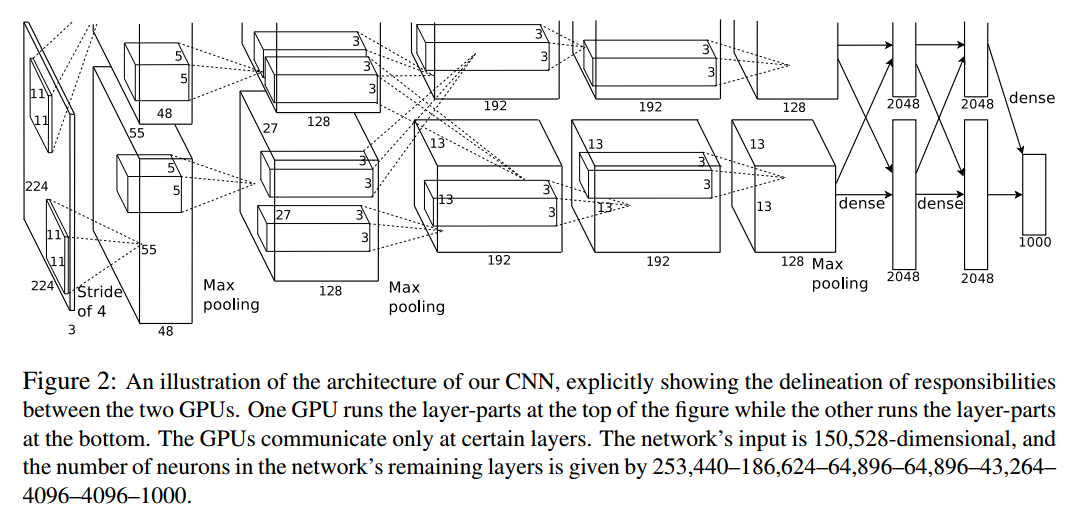
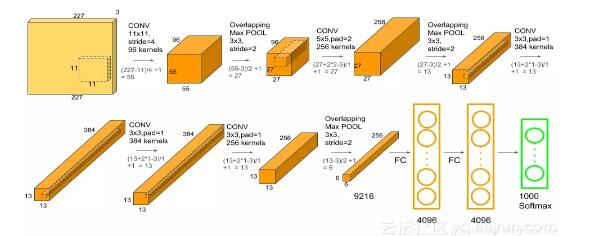

In [1]:
import argparse
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import PIL
from tqdm import tqdm

In [2]:
class AlexNet(nn.Module):
    def __init__(self, args):
        super().__init__()
        ## height = (height_in - height_kernel + 2*padding)/stride + 1
        ## width = (width_in - width_kernel + 2*padding)/stride + 1
        ## 第一层卷积层，kernel_size为3*3，out_channel为96，stride为4，初始图像大小为227*227, padding为2 
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3*3, stride=2, padding=0),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=args.num_class)
        )
    
    def forward(self,x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
class MyDataset(Dataset):
    def __init__(self, data_path, is_train=True, transform=None):
        self.data_path = data_path
        self.is_train = is_train
        if transform is None:
            self.transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(size=(227,227)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transform
        self.path_list = os.listdir(self.data_path) # 列出所有图片命名
        
    
    def __getitem__(self, index):
        filename = self.path_list[index]
        if self.is_train:
            if filename.split(".")[0]=="dog":
                label = 1
            else:
                label = 0
        else:
            label=0
        label = torch.tensor(label, dtype=torch.int64)
        img_path = os.path.join(self.data_path, filename)
        img = PIL.Image.open(img_path)
        img = self.transform(img)
        return img, label
        
    
    def __len__(self):
        return len(self.path_list)     

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--num_class',default=2, type=int, help='分类个数')
parser.add_argument('--use_cuda', action='store_true',help='适用GPU进行训练')
args = parser.parse_args(args=['--num_class', '2', '--use_cuda'])
print(args)

Namespace(num_class=2, use_cuda=True)


In [5]:
device = torch.device("cuda" if args.use_cuda else "cpu")

In [6]:
model = AlexNet(args=args).to(device)

In [7]:
# model
from torchsummary import summary
summary(model, input_size=(3, 227, 227), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          34,848
              ReLU-2           [-1, 96, 56, 56]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,400
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 10, 10]               0
            Conv2d-7          [-1, 384, 10, 10]         884,736
              ReLU-8          [-1, 384, 10, 10]               0
            Conv2d-9          [-1, 256, 10, 10]         884,736
             ReLU-10          [-1, 256, 10, 10]               0
           Conv2d-11          [-1, 256, 10, 10]         589,824
             ReLU-12          [-1, 256, 10, 10]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
AdaptiveAvgPool2d-14            [-1, 25

In [8]:
# sample 调用测试
# train_dataset_sample = torch.rand(2, 3, 227,227).to(device) ## 输入（batch, channel, height, width）
# model(train_dataset_sample)

In [9]:
train_data = MyDataset("../../datasets/cat_dog_dataset/train/", is_train=True)
test_dataset = MyDataset("../../datasets/cat_dog_dataset/test/", is_train=False)
## 查看一张图片
# img_PIL_Tensor = test_dataset[1][0]
# new_img_pil = torchvision.transforms.ToPILImage()(img_PIL_Tensor).convert("RGB")
# new_img_pil

In [10]:
## 划分训练集和验证集
train_size = int(0.8*len(train_data))
dev_size = len(train_data) - train_size

train_dataset, dev_dataset = torch.utils.data.random_split(train_data, [train_size, dev_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=0)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)

In [11]:
## 参数
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr)
loss_func = nn.CrossEntropyLoss(reduction="sum")
save_model_path = "../../results/AlexNet"
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

In [12]:
def compute_metric(pre, label):
    
    return torch.sum(pre.argmax(dim=1).view(-1)==label.view(-1))

In [13]:
## 训练
epochs = 10
model.to(device)

train_loss_epoch_list = []
train_acc_epoch_list = []
dev_loss_epoch_list = []
dev_acc_epoch_list = []
best_score = 0


for epoch in tqdm(range(1, epochs+1)):
    print(f"当前epoch：{epoch}")
    model.train()
    ## 每个epoch中正确的个数
    correct_per_epoch = 0
    ## 每个epoch的loss
    loss_per_epoch = 0
    for step, (data, label) in tqdm(enumerate(train_dataloader)):
        data, label = data.to(device), label.to(device)
        logits = model(data)
        pre = torch.softmax(logits, dim=1) 
        loss = loss_func(logits, label)
        correct_per_epoch += compute_metric(pre, label).item()
        loss_per_epoch+= loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step%100==0:
            print(f'batch_loss:{loss.item()},batch_acc:{compute_metric(pre, label).item()/len(label)*100}%')

        
    train_loss_epoch_list.append(loss_per_epoch/len(train_dataset))
    train_acc_epoch_list.append(correct_per_epoch/len(train_dataset)*100)
    
    ## dev 验证集上的实验结果
    with torch.no_grad():
        print("验证集开始测试")
        dev_loss = 0.0
        correct_dev = 0
        model.eval()
        for dev_step, (dev_data, dev_label) in tqdm(enumerate(dev_dataloader)):
            dev_data, dev_label = dev_data.to(device), dev_label.to(device)
            logits = model(dev_data)
            dev_pre = torch.softmax(logits, dim=1)
            correct_dev += compute_metric(dev_pre, dev_label).item()
            loss = loss_func(logits, dev_label)
            dev_loss+=loss.item()
        current_score = correct_dev/len(dev_dataset)*100
        print(f'dev_loss:{dev_loss},  dev_Acc:{current_score}')
        
        dev_loss_epoch_list.append(dev_loss/len(dev_dataset))
        dev_acc_epoch_list.append(current_score)
        if best_score<current_score:
            best_score=current_score
            print(f"保存模型参数。。。。。。。。。。。best_score{best_score}")
            torch.save(model.state_dict(), os.path.join(save_model_path,'alexnet.pt'))

  0%|          | 0/10 [00:00<?, ?it/s]

当前epoch：1



0it [00:00, ?it/s]
1it [00:00,  5.98it/s]

batch_loss:22.1921443939209,batch_acc:37.5%



2it [00:00,  6.91it/s]
3it [00:00,  7.71it/s]
4it [00:00,  7.84it/s]
5it [00:00,  8.07it/s]
6it [00:00,  8.37it/s]
7it [00:00,  8.28it/s]
8it [00:00,  8.60it/s]
9it [00:01,  8.49it/s]
10it [00:01,  8.61it/s]
11it [00:01,  8.37it/s]
12it [00:01,  8.35it/s]
13it [00:01,  7.88it/s]
14it [00:01,  7.42it/s]
15it [00:01,  7.63it/s]
16it [00:02,  8.04it/s]
17it [00:02,  8.20it/s]
18it [00:02,  8.48it/s]
19it [00:02,  8.52it/s]
20it [00:02,  8.72it/s]
21it [00:02,  8.85it/s]
22it [00:02,  8.94it/s]
23it [00:02,  9.04it/s]
24it [00:02,  8.90it/s]
25it [00:03,  8.96it/s]
26it [00:03,  8.86it/s]
27it [00:03,  8.74it/s]
28it [00:03,  8.27it/s]
29it [00:03,  8.53it/s]
30it [00:03,  8.18it/s]
31it [00:03,  8.32it/s]
32it [00:03,  8.68it/s]
33it [00:04,  7.58it/s]
34it [00:04,  7.92it/s]
35it [00:04,  8.23it/s]
36it [00:04,  8.27it/s]
37it [00:04,  8.58it/s]
38it [00:04,  8.67it/s]
39it [00:04,  7.64it/s]
40it [00:04,  7.90it/s]
41it [00:04,  8.02it/s]
42it [00:05,  8.14it/s]
43it [00:05,  8.45it/s]

batch_loss:22.21010971069336,batch_acc:46.875%



103it [00:12,  7.62it/s]
104it [00:12,  8.04it/s]
105it [00:12,  8.33it/s]
106it [00:12,  8.49it/s]
108it [00:13,  8.84it/s]
109it [00:13,  9.01it/s]
110it [00:13,  9.16it/s]
111it [00:13,  9.23it/s]
112it [00:13,  9.27it/s]
113it [00:13,  9.11it/s]
115it [00:13,  9.18it/s]
116it [00:13,  9.14it/s]
117it [00:14,  8.57it/s]
118it [00:14,  8.78it/s]
119it [00:14,  8.99it/s]
120it [00:14,  8.83it/s]
121it [00:14,  8.74it/s]
122it [00:14,  8.98it/s]
123it [00:14,  9.16it/s]
124it [00:14,  9.13it/s]
125it [00:14,  9.11it/s]
126it [00:15,  9.09it/s]
127it [00:15,  9.00it/s]
128it [00:15,  8.79it/s]
129it [00:15,  8.72it/s]
130it [00:15,  8.93it/s]
131it [00:15,  8.79it/s]
132it [00:15,  8.88it/s]
133it [00:15,  8.76it/s]
134it [00:15,  8.95it/s]
135it [00:16,  8.83it/s]
136it [00:16,  8.49it/s]
137it [00:16,  8.84it/s]
138it [00:16,  8.77it/s]
139it [00:16,  8.97it/s]
140it [00:16,  9.05it/s]
141it [00:16,  9.20it/s]
142it [00:16,  9.25it/s]
143it [00:16,  9.32it/s]
144it [00:17,  9.15it/s]

batch_loss:20.869136810302734,batch_acc:62.5%



203it [00:23,  8.71it/s]
204it [00:23,  8.92it/s]
205it [00:24,  8.97it/s]
206it [00:24,  9.18it/s]
207it [00:24,  9.16it/s]
208it [00:24,  9.09it/s]
209it [00:24,  9.05it/s]
210it [00:24,  8.61it/s]
211it [00:24,  8.87it/s]
212it [00:24,  8.81it/s]
213it [00:24,  8.91it/s]
214it [00:25,  8.90it/s]
215it [00:25,  8.90it/s]
216it [00:25,  6.60it/s]
217it [00:25,  5.86it/s]
218it [00:25,  6.59it/s]
219it [00:25,  7.20it/s]
220it [00:25,  7.47it/s]
221it [00:26,  7.70it/s]
222it [00:26,  8.16it/s]
223it [00:26,  8.19it/s]
224it [00:26,  8.33it/s]
225it [00:26,  8.19it/s]
226it [00:26,  8.24it/s]
227it [00:26,  8.56it/s]
228it [00:26,  8.77it/s]
229it [00:26,  8.99it/s]
230it [00:27,  9.06it/s]
231it [00:27,  9.10it/s]
232it [00:27,  8.98it/s]
233it [00:27,  9.20it/s]
234it [00:27,  9.23it/s]
235it [00:27,  9.21it/s]
236it [00:27,  9.23it/s]
237it [00:27,  9.22it/s]
238it [00:27,  8.90it/s]
239it [00:28,  9.00it/s]
240it [00:28,  9.08it/s]
241it [00:28,  9.03it/s]
242it [00:28,  9.09it/s]

batch_loss:18.160186767578125,batch_acc:71.875%



303it [00:35,  8.23it/s]
304it [00:35,  8.37it/s]
305it [00:35,  8.49it/s]
306it [00:35,  8.54it/s]
307it [00:35,  8.75it/s]
308it [00:35,  8.68it/s]
309it [00:36,  8.71it/s]
310it [00:36,  8.85it/s]
311it [00:36,  9.02it/s]
312it [00:36,  9.21it/s]
313it [00:36,  9.16it/s]
314it [00:36,  9.00it/s]
315it [00:36,  8.66it/s]
316it [00:36,  8.27it/s]
317it [00:37,  8.57it/s]
318it [00:37,  8.68it/s]
319it [00:37,  8.64it/s]
320it [00:37,  8.68it/s]
321it [00:37,  8.53it/s]
322it [00:37,  8.68it/s]
323it [00:37,  8.91it/s]
324it [00:37,  9.06it/s]
325it [00:37,  9.21it/s]
326it [00:38,  9.38it/s]
327it [00:38,  9.02it/s]
329it [00:38,  9.33it/s]
330it [00:38,  8.98it/s]
331it [00:38,  8.96it/s]
332it [00:38,  8.68it/s]
333it [00:38,  8.53it/s]
334it [00:38,  8.78it/s]
335it [00:39,  8.85it/s]
337it [00:39,  9.25it/s]
338it [00:39,  9.25it/s]
339it [00:39,  9.14it/s]
340it [00:39,  9.32it/s]
341it [00:39,  9.15it/s]
342it [00:39,  9.25it/s]
343it [00:39,  9.19it/s]
344it [00:39,  9.04it/s]

batch_loss:19.13353729248047,batch_acc:71.875%



403it [00:46,  8.71it/s]
404it [00:46,  8.83it/s]
405it [00:47,  8.78it/s]
406it [00:47,  8.63it/s]
407it [00:47,  8.85it/s]
408it [00:47,  8.70it/s]
409it [00:47,  8.74it/s]
410it [00:47,  9.04it/s]
411it [00:47,  9.17it/s]
412it [00:47,  9.35it/s]
413it [00:47,  9.08it/s]
414it [00:48,  9.25it/s]
415it [00:48,  9.21it/s]
416it [00:48,  8.48it/s]
417it [00:48,  6.42it/s]
418it [00:48,  6.81it/s]
419it [00:48,  7.37it/s]
420it [00:48,  6.97it/s]
421it [00:49,  7.48it/s]
422it [00:49,  7.76it/s]
423it [00:49,  8.03it/s]
424it [00:49,  8.29it/s]
426it [00:49,  8.11it/s]
427it [00:49,  8.37it/s]
428it [00:49,  8.62it/s]
429it [00:49,  8.79it/s]
430it [00:50,  8.78it/s]
431it [00:50,  8.78it/s]
432it [00:50,  8.75it/s]
433it [00:50,  8.32it/s]
434it [00:50,  8.21it/s]
435it [00:50,  8.20it/s]
436it [00:50,  8.14it/s]
437it [00:50,  8.35it/s]
438it [00:51,  8.43it/s]
439it [00:51,  8.41it/s]
440it [00:51,  8.43it/s]
441it [00:51,  8.16it/s]
442it [00:51,  8.42it/s]
443it [00:51,  8.32it/s]

batch_loss:20.367801666259766,batch_acc:68.75%



503it [00:58,  8.31it/s]
504it [00:58,  8.60it/s]
505it [00:58,  8.72it/s]
506it [00:59,  8.80it/s]
507it [00:59,  8.76it/s]
508it [00:59,  8.80it/s]
509it [00:59,  8.77it/s]
510it [00:59,  8.92it/s]
511it [00:59,  9.05it/s]
512it [00:59,  9.26it/s]
513it [00:59,  8.82it/s]
514it [00:59,  8.91it/s]
515it [01:00,  8.80it/s]
516it [01:00,  8.74it/s]
517it [01:00,  8.59it/s]
518it [01:00,  8.67it/s]
519it [01:00,  8.83it/s]
520it [01:00,  8.36it/s]
521it [01:00,  8.71it/s]
522it [01:00,  8.75it/s]
523it [01:01,  8.94it/s]
524it [01:01,  8.91it/s]
525it [01:01,  9.00it/s]
526it [01:01,  9.19it/s]
527it [01:01,  8.94it/s]
528it [01:01,  9.05it/s]
529it [01:01,  9.03it/s]
530it [01:01,  9.18it/s]
531it [01:01,  9.12it/s]
532it [01:02,  9.14it/s]
533it [01:02,  8.92it/s]
534it [01:02,  8.92it/s]
535it [01:02,  9.08it/s]
536it [01:02,  9.06it/s]
537it [01:02,  9.13it/s]
538it [01:02,  9.10it/s]
539it [01:02,  9.11it/s]
540it [01:02,  9.15it/s]
541it [01:03,  9.25it/s]
542it [01:03,  9.42it/s]

batch_loss:17.00657081604004,batch_acc:68.75%



603it [01:10,  8.20it/s]
604it [01:10,  6.93it/s]
605it [01:10,  7.27it/s]
606it [01:10,  7.80it/s]
607it [01:11,  7.87it/s]
608it [01:11,  7.90it/s]
609it [01:11,  8.31it/s]
610it [01:11,  8.37it/s]
611it [01:11,  8.67it/s]
612it [01:11,  8.87it/s]
613it [01:11,  8.97it/s]
614it [01:11,  8.83it/s]
615it [01:11,  8.94it/s]
616it [01:12,  9.10it/s]
617it [01:12,  9.12it/s]
618it [01:12,  9.27it/s]
619it [01:12,  9.02it/s]
620it [01:12,  9.14it/s]
621it [01:12,  8.99it/s]
622it [01:12,  8.91it/s]
623it [01:12,  8.84it/s]
624it [01:12,  9.01it/s]
625it [01:13,  8.56it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  8.09it/s]
2it [00:00,  9.10it/s]
3it [00:00,  9.05it/s]
4it [00:00,  9.09it/s]
5it [00:00,  9.17it/s]
6it [00:00,  9.16it/s]
7it [00:00,  9.29it/s]
8it [00:00,  9.15it/s]
9it [00:00,  8.90it/s]
10it [00:01,  9.01it/s]
11it [00:01,  8.91it/s]
12it [00:01,  8.92it/s]
13it [00:01,  8.96it/s]
14it [00:01,  9.15it/s]
15it [00:01,  8.90it/s]
16it [00:01,  9.02it/s]
17it [00:01,  9.29it/s]
18it [00:01,  9.35it/s]
19it [00:02,  9.35it/s]
20it [00:02,  8.55it/s]
21it [00:02,  8.55it/s]
22it [00:02,  8.71it/s]
23it [00:02,  8.26it/s]
24it [00:02,  8.35it/s]
25it [00:02,  8.49it/s]
26it [00:02,  8.24it/s]
27it [00:03,  8.46it/s]
28it [00:03,  8.60it/s]
29it [00:03,  8.80it/s]
30it [00:03,  8.94it/s]
31it [00:03,  8.89it/s]
32it [00:03,  9.02it/s]
33it [00:03,  8.98it/s]
34it [00:03,  8.67it/s]
35it [00:03,  8.79it/s]
36it [00:04,  8.84it/s]
37it [00:04,  8.95it/s]
38it [00:04,  8.69it/s]
39it [00:04,  8.84it/s]
40it [00:04,  9.01it/s]
41it [00:04,  8.91it/s]
42it 

dev_loss:2953.6130056381226,  dev_Acc:69.08
保存模型参数。。。。。。。。。。。best_score69.08


 10%|█         | 1/10 [01:31<13:43, 91.49s/it]

当前epoch：2



0it [00:00, ?it/s]
1it [00:00,  5.97it/s]

batch_loss:19.090435028076172,batch_acc:68.75%



2it [00:00,  7.41it/s]
3it [00:00,  8.01it/s]
4it [00:00,  8.53it/s]
5it [00:00,  8.53it/s]
6it [00:00,  8.72it/s]
7it [00:00,  8.81it/s]
8it [00:00,  8.63it/s]
9it [00:01,  8.70it/s]
10it [00:01,  8.51it/s]
11it [00:01,  8.86it/s]
12it [00:01,  8.99it/s]
13it [00:01,  8.93it/s]
14it [00:01,  8.69it/s]
15it [00:01,  8.61it/s]
16it [00:01,  8.28it/s]
17it [00:01,  8.53it/s]
18it [00:02,  8.33it/s]
19it [00:02,  6.79it/s]
20it [00:02,  6.73it/s]
21it [00:02,  7.37it/s]
22it [00:02,  7.79it/s]
23it [00:02,  7.94it/s]
24it [00:02,  8.25it/s]
25it [00:03,  8.53it/s]
26it [00:03,  7.82it/s]
28it [00:03,  8.66it/s]
29it [00:03,  8.91it/s]
30it [00:03,  8.77it/s]
31it [00:03,  8.80it/s]
32it [00:03,  9.00it/s]
33it [00:03,  9.01it/s]
34it [00:04,  8.99it/s]
35it [00:04,  8.66it/s]
36it [00:04,  8.87it/s]
37it [00:04,  8.64it/s]
38it [00:04,  8.65it/s]
39it [00:04,  8.64it/s]
40it [00:04,  8.33it/s]
41it [00:04,  8.55it/s]
42it [00:05,  8.36it/s]
43it [00:05,  8.54it/s]
44it [00:05,  8.65it/s]

batch_loss:19.921926498413086,batch_acc:56.25%



103it [00:12,  8.71it/s]
104it [00:12,  8.69it/s]
105it [00:12,  8.63it/s]
106it [00:12,  8.66it/s]
107it [00:12,  8.73it/s]
108it [00:12,  8.88it/s]
109it [00:12,  8.87it/s]
110it [00:12,  8.73it/s]
111it [00:13,  8.75it/s]
112it [00:13,  8.85it/s]
113it [00:13,  8.98it/s]
114it [00:13,  9.19it/s]
115it [00:13,  9.08it/s]
116it [00:13,  9.27it/s]
117it [00:13,  9.14it/s]
118it [00:13,  9.02it/s]
119it [00:13,  8.88it/s]
121it [00:14,  9.02it/s]
122it [00:14,  9.06it/s]
123it [00:14,  8.57it/s]
124it [00:14,  8.70it/s]
125it [00:14,  8.80it/s]
126it [00:14,  8.76it/s]
127it [00:14,  8.82it/s]
128it [00:14,  8.90it/s]
129it [00:15,  8.20it/s]
130it [00:15,  8.15it/s]
131it [00:15,  8.14it/s]
132it [00:15,  8.22it/s]
133it [00:15,  8.42it/s]
134it [00:15,  8.41it/s]
135it [00:15,  8.55it/s]
136it [00:15,  8.47it/s]
137it [00:16,  8.36it/s]
138it [00:16,  8.52it/s]
139it [00:16,  8.83it/s]
140it [00:16,  8.87it/s]
141it [00:16,  8.19it/s]
142it [00:16,  8.43it/s]
143it [00:16,  8.08it/s]

batch_loss:14.738653182983398,batch_acc:81.25%



203it [00:23,  8.46it/s]
204it [00:23,  7.43it/s]
205it [00:24,  6.23it/s]
206it [00:24,  6.77it/s]
207it [00:24,  7.11it/s]
208it [00:24,  7.24it/s]
209it [00:24,  7.63it/s]
210it [00:24,  7.87it/s]
211it [00:24,  8.02it/s]
212it [00:25,  8.23it/s]
213it [00:25,  8.47it/s]
214it [00:25,  8.23it/s]
215it [00:25,  8.41it/s]
216it [00:25,  7.73it/s]
217it [00:25,  7.90it/s]
218it [00:25,  7.65it/s]
219it [00:25,  7.94it/s]
220it [00:26,  8.29it/s]
221it [00:26,  8.27it/s]
222it [00:26,  8.48it/s]
223it [00:26,  8.81it/s]
224it [00:26,  9.06it/s]
225it [00:26,  8.94it/s]
226it [00:26,  9.16it/s]
227it [00:26,  8.86it/s]
228it [00:26,  8.49it/s]
229it [00:27,  8.73it/s]
230it [00:27,  8.90it/s]
231it [00:27,  8.99it/s]
232it [00:27,  9.16it/s]
233it [00:27,  9.19it/s]
234it [00:27,  8.79it/s]
235it [00:27,  8.83it/s]
236it [00:27,  8.91it/s]
237it [00:27,  8.71it/s]
238it [00:28,  8.94it/s]
239it [00:28,  9.15it/s]
240it [00:28,  9.27it/s]
241it [00:28,  9.38it/s]
242it [00:28,  9.01it/s]

batch_loss:16.679790496826172,batch_acc:78.125%



303it [00:35,  8.59it/s]
304it [00:35,  7.59it/s]
305it [00:36,  7.68it/s]
306it [00:36,  7.99it/s]
307it [00:36,  8.40it/s]
308it [00:36,  8.72it/s]
309it [00:36,  8.78it/s]
310it [00:36,  8.95it/s]
311it [00:36,  8.68it/s]
312it [00:36,  8.53it/s]
313it [00:36,  8.45it/s]
314it [00:37,  8.52it/s]
315it [00:37,  8.59it/s]
316it [00:37,  8.63it/s]
317it [00:37,  8.54it/s]
318it [00:37,  8.60it/s]
319it [00:37,  8.55it/s]
320it [00:37,  8.73it/s]
321it [00:37,  8.68it/s]
322it [00:38,  8.78it/s]
323it [00:38,  8.80it/s]
324it [00:38,  9.02it/s]
325it [00:38,  9.14it/s]
326it [00:38,  8.88it/s]
327it [00:38,  8.98it/s]
328it [00:38,  9.04it/s]
329it [00:38,  8.98it/s]
330it [00:38,  8.15it/s]
331it [00:39,  6.75it/s]
332it [00:39,  7.04it/s]
333it [00:39,  7.60it/s]
334it [00:39,  7.83it/s]
335it [00:39,  7.84it/s]
336it [00:39,  8.00it/s]
337it [00:39,  8.17it/s]
338it [00:39,  8.51it/s]
339it [00:40,  8.62it/s]
340it [00:40,  8.65it/s]
341it [00:40,  8.66it/s]
342it [00:40,  8.88it/s]

batch_loss:13.354385375976562,batch_acc:84.375%



403it [00:47,  7.90it/s]
404it [00:47,  7.41it/s]
405it [00:47,  7.86it/s]
406it [00:47,  7.99it/s]
407it [00:47,  8.46it/s]
408it [00:47,  8.65it/s]
409it [00:48,  8.66it/s]
410it [00:48,  8.10it/s]
411it [00:48,  8.28it/s]
412it [00:48,  7.93it/s]
414it [00:48,  8.66it/s]
415it [00:48,  8.75it/s]
416it [00:48,  8.67it/s]
417it [00:49,  8.74it/s]
418it [00:49,  8.87it/s]
419it [00:49,  8.89it/s]
420it [00:49,  8.49it/s]
421it [00:49,  8.88it/s]
422it [00:49,  8.93it/s]
423it [00:49,  8.95it/s]
424it [00:49,  9.20it/s]
425it [00:49,  9.10it/s]
426it [00:50,  9.13it/s]
427it [00:50,  9.00it/s]
428it [00:50,  9.02it/s]
429it [00:50,  9.05it/s]
430it [00:50,  9.26it/s]
431it [00:50,  9.30it/s]
432it [00:50,  9.42it/s]
433it [00:50,  9.28it/s]
434it [00:50,  8.85it/s]
435it [00:51,  8.87it/s]
436it [00:51,  8.74it/s]
437it [00:51,  8.86it/s]
438it [00:51,  8.73it/s]
439it [00:51,  8.66it/s]
440it [00:51,  8.52it/s]
442it [00:51,  9.12it/s]
443it [00:51,  9.14it/s]
444it [00:52,  9.23it/s]

batch_loss:14.973217010498047,batch_acc:81.25%



503it [00:58,  8.69it/s]
504it [00:59,  8.59it/s]
505it [00:59,  8.63it/s]
506it [00:59,  8.96it/s]
507it [00:59,  8.80it/s]
508it [00:59,  8.73it/s]
509it [00:59,  8.92it/s]
510it [00:59,  8.96it/s]
511it [00:59,  8.87it/s]
512it [00:59,  8.95it/s]
513it [01:00,  8.95it/s]
514it [01:00,  8.90it/s]
515it [01:00,  8.94it/s]
516it [01:00,  9.19it/s]
517it [01:00,  9.21it/s]
518it [01:00,  9.00it/s]
519it [01:00,  8.97it/s]
520it [01:00,  8.92it/s]
521it [01:00,  8.88it/s]
522it [01:01,  8.91it/s]
523it [01:01,  8.70it/s]
524it [01:01,  8.68it/s]
525it [01:01,  8.69it/s]
526it [01:01,  8.69it/s]
527it [01:01,  8.54it/s]
529it [01:01,  8.41it/s]
530it [01:01,  8.69it/s]
531it [01:02,  8.82it/s]
532it [01:02,  8.70it/s]
533it [01:02,  8.57it/s]
534it [01:02,  7.67it/s]
535it [01:02,  7.96it/s]
536it [01:02,  8.18it/s]
537it [01:02,  8.30it/s]
538it [01:02,  8.57it/s]
539it [01:03,  8.56it/s]
540it [01:03,  7.90it/s]
541it [01:03,  8.11it/s]
542it [01:03,  8.16it/s]
543it [01:03,  8.43it/s]

batch_loss:14.270874977111816,batch_acc:78.125%



603it [01:10,  8.45it/s]
604it [01:10,  8.63it/s]
605it [01:10,  8.70it/s]
606it [01:10,  8.96it/s]
607it [01:11,  8.93it/s]
608it [01:11,  8.80it/s]
609it [01:11,  8.87it/s]
610it [01:11,  8.92it/s]
611it [01:11,  8.77it/s]
612it [01:11,  8.90it/s]
613it [01:11,  8.95it/s]
614it [01:11,  8.83it/s]
615it [01:12,  8.80it/s]
616it [01:12,  8.95it/s]
617it [01:12,  8.89it/s]
618it [01:12,  8.89it/s]
619it [01:12,  9.05it/s]
620it [01:12,  9.19it/s]
621it [01:12,  9.19it/s]
622it [01:12,  9.18it/s]
623it [01:12,  8.86it/s]
624it [01:13,  8.37it/s]
625it [01:13,  8.54it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  7.25it/s]
2it [00:00,  8.22it/s]
3it [00:00,  8.63it/s]
4it [00:00,  9.01it/s]
5it [00:00,  8.89it/s]
6it [00:00,  8.59it/s]
7it [00:00,  8.77it/s]
8it [00:00,  8.71it/s]
9it [00:01,  8.96it/s]
10it [00:01,  9.06it/s]
11it [00:01,  8.93it/s]
12it [00:01,  8.95it/s]
13it [00:01,  8.97it/s]
14it [00:01,  9.05it/s]
15it [00:01,  9.27it/s]
16it [00:01,  9.27it/s]
17it [00:01,  9.31it/s]
18it [00:02,  9.38it/s]
19it [00:02,  9.14it/s]
20it [00:02,  8.81it/s]
21it [00:02,  8.98it/s]
22it [00:02,  9.04it/s]
23it [00:02,  8.99it/s]
24it [00:02,  9.21it/s]
25it [00:02,  9.02it/s]
26it [00:02,  9.28it/s]
27it [00:02,  9.29it/s]
28it [00:03,  8.90it/s]
29it [00:03,  9.10it/s]
30it [00:03,  8.79it/s]
31it [00:03,  8.65it/s]
32it [00:03,  7.94it/s]
33it [00:03,  8.18it/s]
34it [00:03,  8.42it/s]
35it [00:03,  8.49it/s]
36it [00:04,  8.56it/s]
37it [00:04,  8.72it/s]
38it [00:04,  7.57it/s]
39it [00:04,  7.75it/s]
40it [00:04,  7.90it/s]
41it [00:04,  8.01it/s]
42it 

dev_loss:2299.800226211548,  dev_Acc:78.64
保存模型参数。。。。。。。。。。。best_score78.64


 20%|██        | 2/10 [03:03<12:13, 91.70s/it]

当前epoch：3



0it [00:00, ?it/s]
1it [00:00,  7.05it/s]

batch_loss:18.171274185180664,batch_acc:75.0%



2it [00:00,  7.74it/s]
3it [00:00,  8.20it/s]
4it [00:00,  8.56it/s]
5it [00:00,  7.43it/s]
6it [00:00,  7.86it/s]
7it [00:00,  8.11it/s]
8it [00:01,  8.04it/s]
9it [00:01,  8.24it/s]
10it [00:01,  8.30it/s]
11it [00:01,  7.66it/s]
12it [00:01,  8.02it/s]
13it [00:01,  8.18it/s]
14it [00:01,  8.54it/s]
15it [00:01,  8.40it/s]
16it [00:01,  8.35it/s]
17it [00:02,  8.63it/s]
18it [00:02,  8.68it/s]
19it [00:02,  8.70it/s]
20it [00:02,  8.55it/s]
21it [00:02,  8.65it/s]
22it [00:02,  8.53it/s]
23it [00:02,  8.73it/s]
24it [00:02,  8.81it/s]
25it [00:02,  8.86it/s]
26it [00:03,  8.62it/s]
27it [00:03,  6.42it/s]
28it [00:03,  7.01it/s]
29it [00:03,  7.58it/s]
30it [00:03,  8.04it/s]
31it [00:03,  8.21it/s]
32it [00:03,  8.65it/s]
33it [00:04,  8.81it/s]
34it [00:04,  8.77it/s]
35it [00:04,  8.95it/s]
36it [00:04,  9.03it/s]
37it [00:04,  8.93it/s]
39it [00:04,  9.01it/s]
40it [00:04,  9.24it/s]
41it [00:04,  9.15it/s]
42it [00:04,  9.15it/s]
44it [00:05,  9.20it/s]
45it [00:05,  9.31it/s]

batch_loss:13.671045303344727,batch_acc:78.125%



103it [00:12,  8.45it/s]
104it [00:12,  8.74it/s]
105it [00:12,  8.54it/s]
106it [00:12,  8.47it/s]
107it [00:12,  8.50it/s]
108it [00:12,  8.62it/s]
109it [00:12,  8.78it/s]
110it [00:13,  8.80it/s]
111it [00:13,  8.77it/s]
112it [00:13,  8.83it/s]
113it [00:13,  8.87it/s]
114it [00:13,  9.01it/s]
115it [00:13,  9.01it/s]
116it [00:13,  9.15it/s]
117it [00:13,  8.74it/s]
118it [00:14,  8.92it/s]
119it [00:14,  8.61it/s]
120it [00:14,  8.76it/s]
121it [00:14,  8.67it/s]
122it [00:14,  8.55it/s]
123it [00:14,  8.52it/s]
124it [00:14,  8.65it/s]
126it [00:14,  8.70it/s]
127it [00:15,  8.69it/s]
128it [00:15,  8.75it/s]
129it [00:15,  8.71it/s]
130it [00:15,  8.58it/s]
131it [00:15,  8.63it/s]
132it [00:15,  7.74it/s]
133it [00:15,  8.05it/s]
134it [00:15,  8.20it/s]
135it [00:16,  8.52it/s]
136it [00:16,  8.49it/s]
137it [00:16,  8.72it/s]
138it [00:16,  7.93it/s]
139it [00:16,  8.22it/s]
140it [00:16,  8.33it/s]
141it [00:16,  8.43it/s]
142it [00:16,  8.78it/s]
143it [00:16,  9.07it/s]

batch_loss:15.625574111938477,batch_acc:75.0%



204it [00:24,  8.89it/s]
205it [00:24,  8.99it/s]
206it [00:24,  8.86it/s]
207it [00:24,  8.93it/s]
208it [00:24,  9.13it/s]
209it [00:24,  9.01it/s]
210it [00:24,  9.03it/s]
211it [00:24,  9.09it/s]
212it [00:24,  9.16it/s]
213it [00:25,  8.96it/s]
214it [00:25,  9.16it/s]
215it [00:25,  9.14it/s]
216it [00:25,  9.18it/s]
217it [00:25,  9.31it/s]
218it [00:25,  9.23it/s]
219it [00:25,  9.04it/s]
220it [00:25,  9.06it/s]
221it [00:25,  8.92it/s]
222it [00:26,  8.87it/s]
223it [00:26,  8.94it/s]
224it [00:26,  8.93it/s]
225it [00:26,  8.73it/s]
226it [00:26,  8.79it/s]
227it [00:26,  8.74it/s]
228it [00:26,  8.89it/s]
229it [00:26,  8.91it/s]
230it [00:26,  8.65it/s]
231it [00:27,  8.80it/s]
232it [00:27,  8.57it/s]
233it [00:27,  8.80it/s]
234it [00:27,  8.67it/s]
235it [00:27,  8.73it/s]
236it [00:27,  8.47it/s]
237it [00:27,  8.50it/s]
238it [00:27,  8.47it/s]
239it [00:27,  8.43it/s]
240it [00:28,  8.28it/s]
241it [00:28,  8.42it/s]
242it [00:28,  8.74it/s]
243it [00:28,  8.34it/s]

batch_loss:15.359570503234863,batch_acc:84.375%



303it [00:35,  8.69it/s]
304it [00:35,  8.71it/s]
305it [00:35,  8.79it/s]
306it [00:35,  8.83it/s]
307it [00:35,  8.62it/s]
308it [00:35,  8.65it/s]
309it [00:36,  8.79it/s]
310it [00:36,  8.81it/s]
311it [00:36,  8.84it/s]
312it [00:36,  8.78it/s]
313it [00:36,  8.70it/s]
314it [00:36,  8.53it/s]
315it [00:36,  8.52it/s]
316it [00:36,  8.73it/s]
317it [00:36,  8.79it/s]
318it [00:37,  8.13it/s]
319it [00:37,  6.77it/s]
320it [00:37,  7.30it/s]
321it [00:37,  7.70it/s]
322it [00:37,  7.84it/s]
323it [00:37,  7.72it/s]
324it [00:37,  7.87it/s]
325it [00:37,  8.23it/s]
326it [00:38,  8.03it/s]
327it [00:38,  7.64it/s]
328it [00:38,  7.84it/s]
329it [00:38,  8.09it/s]
330it [00:38,  8.06it/s]
331it [00:38,  8.35it/s]
332it [00:38,  8.38it/s]
333it [00:38,  8.58it/s]
334it [00:39,  8.46it/s]
335it [00:39,  8.64it/s]
336it [00:39,  8.54it/s]
337it [00:39,  8.46it/s]
338it [00:39,  8.58it/s]
339it [00:39,  8.60it/s]
340it [00:39,  8.51it/s]
341it [00:39,  8.43it/s]
342it [00:40,  8.79it/s]

batch_loss:12.011812210083008,batch_acc:78.125%



403it [00:47,  8.26it/s]
404it [00:47,  8.49it/s]
405it [00:47,  8.72it/s]
406it [00:47,  8.67it/s]
407it [00:47,  8.83it/s]
408it [00:47,  8.71it/s]
410it [00:47,  9.10it/s]
411it [00:47,  9.18it/s]
412it [00:48,  9.24it/s]
413it [00:48,  9.05it/s]
414it [00:48,  9.03it/s]
415it [00:48,  9.03it/s]
416it [00:48,  8.58it/s]
417it [00:48,  8.23it/s]
418it [00:48,  8.15it/s]
419it [00:48,  8.07it/s]
421it [00:49,  8.50it/s]
422it [00:49,  8.54it/s]
423it [00:49,  8.45it/s]
424it [00:49,  8.61it/s]
425it [00:49,  8.79it/s]
426it [00:49,  8.70it/s]
427it [00:49,  8.79it/s]
428it [00:49,  8.88it/s]
429it [00:50,  8.98it/s]
430it [00:50,  9.14it/s]
431it [00:50,  9.28it/s]
432it [00:50,  9.24it/s]
433it [00:50,  9.15it/s]
434it [00:50,  9.06it/s]
435it [00:50,  9.05it/s]
436it [00:50,  8.88it/s]
437it [00:50,  8.85it/s]
438it [00:51,  8.87it/s]
439it [00:51,  8.70it/s]
440it [00:51,  8.87it/s]
441it [00:51,  8.81it/s]
442it [00:51,  8.82it/s]
443it [00:51,  8.58it/s]
444it [00:51,  8.60it/s]

batch_loss:11.714284896850586,batch_acc:75.0%



503it [00:58,  8.77it/s]
504it [00:58,  8.98it/s]
505it [00:58,  8.96it/s]
506it [00:58,  8.65it/s]
507it [00:59,  8.46it/s]
508it [00:59,  8.21it/s]
509it [00:59,  8.17it/s]
510it [00:59,  8.05it/s]
511it [00:59,  8.43it/s]
512it [00:59,  8.51it/s]
513it [00:59,  8.82it/s]
514it [00:59,  8.78it/s]
515it [01:00,  8.18it/s]
517it [01:00,  8.84it/s]
518it [01:00,  8.80it/s]
519it [01:00,  8.90it/s]
520it [01:00,  9.07it/s]
521it [01:00,  8.18it/s]
522it [01:00,  8.39it/s]
523it [01:00,  8.62it/s]
524it [01:01,  8.44it/s]
525it [01:01,  8.82it/s]
526it [01:01,  8.76it/s]
527it [01:01,  7.76it/s]
528it [01:01,  8.07it/s]
529it [01:01,  8.40it/s]
530it [01:01,  8.76it/s]
531it [01:01,  8.69it/s]
532it [01:01,  8.79it/s]
533it [01:02,  8.88it/s]
534it [01:02,  8.98it/s]
535it [01:02,  9.20it/s]
536it [01:02,  9.01it/s]
537it [01:02,  9.04it/s]
538it [01:02,  9.06it/s]
539it [01:02,  8.96it/s]
540it [01:02,  9.02it/s]
542it [01:03,  9.46it/s]
543it [01:03,  9.00it/s]
544it [01:03,  8.90it/s]

batch_loss:10.425643920898438,batch_acc:87.5%



603it [01:10,  8.23it/s]
604it [01:10,  8.30it/s]
605it [01:10,  8.66it/s]
606it [01:10,  8.76it/s]
607it [01:10,  8.63it/s]
608it [01:10,  8.74it/s]
609it [01:11,  8.87it/s]
610it [01:11,  8.96it/s]
611it [01:11,  9.00it/s]
612it [01:11,  8.56it/s]
613it [01:11,  8.68it/s]
614it [01:11,  8.74it/s]
615it [01:11,  8.83it/s]
616it [01:11,  8.92it/s]
617it [01:11,  8.94it/s]
618it [01:12,  8.83it/s]
619it [01:12,  8.87it/s]
620it [01:12,  8.61it/s]
621it [01:12,  8.50it/s]
622it [01:12,  8.59it/s]
623it [01:12,  8.59it/s]
624it [01:12,  8.72it/s]
625it [01:12,  8.57it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  9.65it/s]
2it [00:00,  9.15it/s]
3it [00:00,  9.15it/s]
4it [00:00,  8.57it/s]
5it [00:00,  8.53it/s]
6it [00:00,  8.61it/s]
7it [00:00,  8.61it/s]
8it [00:00,  8.88it/s]
9it [00:01,  8.79it/s]
10it [00:01,  8.96it/s]
11it [00:01,  8.91it/s]
12it [00:01,  8.75it/s]
13it [00:01,  8.98it/s]
14it [00:01,  8.53it/s]
15it [00:01,  8.66it/s]
16it [00:01,  8.80it/s]
17it [00:01,  8.96it/s]
18it [00:02,  7.83it/s]
19it [00:02,  8.17it/s]
20it [00:02,  8.04it/s]
21it [00:02,  7.95it/s]
22it [00:02,  8.12it/s]
23it [00:02,  7.59it/s]
24it [00:02,  7.97it/s]
26it [00:03,  8.65it/s]
27it [00:03,  8.85it/s]
28it [00:03,  8.86it/s]
29it [00:03,  7.94it/s]
30it [00:03,  8.17it/s]
31it [00:03,  8.44it/s]
32it [00:03,  8.49it/s]
33it [00:03,  8.55it/s]
34it [00:03,  8.78it/s]
35it [00:04,  8.97it/s]
36it [00:04,  8.87it/s]
37it [00:04,  8.98it/s]
38it [00:04,  8.64it/s]
39it [00:04,  8.89it/s]
40it [00:04,  9.17it/s]
41it [00:04,  8.92it/s]
42it [00:04,  8.82it/s]
43it 

dev_loss:2131.9546644687653,  dev_Acc:80.25999999999999
保存模型参数。。。。。。。。。。。best_score80.25999999999999


 30%|███       | 3/10 [04:34<10:41, 91.68s/it]

当前epoch：4



0it [00:00, ?it/s]
1it [00:00,  6.01it/s]

batch_loss:10.007168769836426,batch_acc:87.5%



2it [00:00,  7.77it/s]
3it [00:00,  7.95it/s]
4it [00:00,  8.22it/s]
5it [00:00,  8.51it/s]
6it [00:00,  8.74it/s]
7it [00:00,  8.95it/s]
8it [00:00,  8.98it/s]
9it [00:01,  9.21it/s]
10it [00:01,  9.08it/s]
11it [00:01,  9.02it/s]
12it [00:01,  9.07it/s]
13it [00:01,  9.11it/s]
14it [00:01,  9.04it/s]
15it [00:01,  8.05it/s]
16it [00:01,  8.04it/s]
17it [00:01,  8.24it/s]
18it [00:02,  8.51it/s]
19it [00:02,  8.79it/s]
20it [00:02,  8.77it/s]
21it [00:02,  8.50it/s]
22it [00:02,  8.66it/s]
23it [00:02,  8.75it/s]
24it [00:02,  8.77it/s]
25it [00:02,  8.62it/s]
26it [00:03,  8.61it/s]
27it [00:03,  8.54it/s]
28it [00:03,  8.56it/s]
29it [00:03,  8.35it/s]
31it [00:03,  8.67it/s]
32it [00:03,  8.48it/s]
33it [00:03,  8.48it/s]
34it [00:03,  8.50it/s]
35it [00:04,  8.60it/s]
36it [00:04,  8.91it/s]
37it [00:04,  9.12it/s]
38it [00:04,  9.01it/s]
39it [00:04,  9.06it/s]
40it [00:04,  8.91it/s]
41it [00:04,  8.85it/s]
42it [00:04,  8.72it/s]
43it [00:04,  8.79it/s]
44it [00:05,  8.84it/s]

batch_loss:10.432177543640137,batch_acc:84.375%



103it [00:11,  8.59it/s]
104it [00:12,  8.68it/s]
105it [00:12,  8.52it/s]
106it [00:12,  8.64it/s]
107it [00:12,  8.77it/s]
108it [00:12,  8.92it/s]
109it [00:12,  8.75it/s]
110it [00:12,  8.71it/s]
111it [00:12,  8.56it/s]
112it [00:12,  8.74it/s]
113it [00:13,  8.76it/s]
114it [00:13,  8.58it/s]
115it [00:13,  7.85it/s]
116it [00:13,  8.26it/s]
117it [00:13,  8.35it/s]
118it [00:13,  8.61it/s]
119it [00:13,  8.58it/s]
120it [00:13,  8.75it/s]
121it [00:14,  7.82it/s]
122it [00:14,  7.85it/s]
123it [00:14,  8.03it/s]
124it [00:14,  8.24it/s]
125it [00:14,  8.45it/s]
126it [00:14,  7.79it/s]
127it [00:14,  8.20it/s]
128it [00:14,  8.43it/s]
129it [00:14,  8.78it/s]
130it [00:15,  8.84it/s]
131it [00:15,  8.92it/s]
132it [00:15,  8.94it/s]
133it [00:15,  8.89it/s]
134it [00:15,  9.09it/s]
135it [00:15,  8.95it/s]
136it [00:15,  8.78it/s]
137it [00:15,  8.86it/s]
138it [00:15,  8.83it/s]
139it [00:16,  9.09it/s]
140it [00:16,  9.12it/s]
141it [00:16,  8.94it/s]
142it [00:16,  8.92it/s]

batch_loss:10.451327323913574,batch_acc:81.25%



203it [00:23,  8.79it/s]
205it [00:23,  9.01it/s]
206it [00:24,  8.84it/s]
207it [00:24,  8.91it/s]
208it [00:24,  8.88it/s]
209it [00:24,  8.54it/s]
210it [00:24,  8.62it/s]
212it [00:24,  9.03it/s]
213it [00:24,  8.94it/s]
214it [00:24,  8.55it/s]
215it [00:25,  8.70it/s]
217it [00:25,  9.08it/s]
218it [00:25,  9.07it/s]
219it [00:25,  9.12it/s]
220it [00:25,  8.81it/s]
221it [00:25,  8.83it/s]
222it [00:25,  8.95it/s]
223it [00:25,  8.88it/s]
224it [00:26,  8.80it/s]
225it [00:26,  9.04it/s]
226it [00:26,  9.17it/s]
227it [00:26,  9.11it/s]
228it [00:26,  8.91it/s]
229it [00:26,  8.90it/s]
230it [00:26,  8.83it/s]
231it [00:26,  9.07it/s]
232it [00:26,  9.17it/s]
233it [00:27,  9.26it/s]
234it [00:27,  9.15it/s]
235it [00:27,  9.11it/s]
236it [00:27,  9.10it/s]
237it [00:27,  9.21it/s]
238it [00:27,  9.14it/s]
239it [00:27,  9.22it/s]
240it [00:27,  9.07it/s]
241it [00:27,  8.88it/s]
242it [00:28,  9.04it/s]
243it [00:28,  8.64it/s]
244it [00:28,  7.93it/s]
245it [00:28,  8.08it/s]

batch_loss:11.450782775878906,batch_acc:81.25%



303it [00:35,  8.51it/s]
304it [00:35,  7.97it/s]
305it [00:35,  6.70it/s]
306it [00:35,  7.39it/s]
307it [00:35,  7.64it/s]
308it [00:35,  7.93it/s]
309it [00:36,  8.01it/s]
310it [00:36,  8.25it/s]
311it [00:36,  8.32it/s]
312it [00:36,  8.42it/s]
313it [00:36,  8.43it/s]
314it [00:36,  8.75it/s]
315it [00:36,  8.76it/s]
317it [00:36,  8.80it/s]
318it [00:37,  8.96it/s]
319it [00:37,  8.84it/s]
320it [00:37,  9.06it/s]
321it [00:37,  9.07it/s]
322it [00:37,  9.18it/s]
323it [00:37,  9.19it/s]
324it [00:37,  9.04it/s]
325it [00:37,  9.29it/s]
326it [00:37,  9.30it/s]
327it [00:38,  9.36it/s]
328it [00:38,  9.36it/s]
329it [00:38,  9.32it/s]
330it [00:38,  8.92it/s]
331it [00:38,  8.86it/s]
332it [00:38,  8.75it/s]
333it [00:38,  8.66it/s]
334it [00:38,  8.75it/s]
335it [00:38,  8.82it/s]
336it [00:39,  8.93it/s]
337it [00:39,  9.02it/s]
338it [00:39,  9.13it/s]
339it [00:39,  9.09it/s]
340it [00:39,  9.08it/s]
341it [00:39,  8.97it/s]
342it [00:39,  8.99it/s]
343it [00:39,  9.23it/s]

batch_loss:6.530013084411621,batch_acc:93.75%



403it [00:46,  8.44it/s]
404it [00:46,  8.46it/s]
405it [00:47,  8.43it/s]
406it [00:47,  8.67it/s]
407it [00:47,  8.69it/s]
408it [00:47,  8.74it/s]
409it [00:47,  8.29it/s]
410it [00:47,  8.41it/s]
411it [00:47,  8.24it/s]
412it [00:47,  8.54it/s]
413it [00:47,  8.92it/s]
414it [00:48,  8.80it/s]
415it [00:48,  8.87it/s]
416it [00:48,  8.93it/s]
417it [00:48,  9.18it/s]
418it [00:48,  8.63it/s]
419it [00:48,  8.74it/s]
420it [00:48,  8.84it/s]
421it [00:48,  8.87it/s]
422it [00:48,  8.78it/s]
423it [00:49,  8.63it/s]
424it [00:49,  8.73it/s]
425it [00:49,  8.71it/s]
426it [00:49,  8.90it/s]
427it [00:49,  8.95it/s]
428it [00:49,  8.93it/s]
429it [00:49,  9.08it/s]
430it [00:49,  8.99it/s]
431it [00:49,  9.12it/s]
432it [00:50,  9.14it/s]
433it [00:50,  9.15it/s]
434it [00:50,  8.78it/s]
435it [00:50,  6.48it/s]
436it [00:50,  7.10it/s]
437it [00:50,  7.59it/s]
438it [00:50,  7.97it/s]
439it [00:51,  7.76it/s]
440it [00:51,  8.19it/s]
441it [00:51,  6.98it/s]
442it [00:51,  7.55it/s]

batch_loss:14.475519180297852,batch_acc:78.125%



503it [00:58,  7.56it/s]
504it [00:58,  7.64it/s]
505it [00:58,  8.06it/s]
506it [00:58,  7.19it/s]
507it [00:59,  7.56it/s]
508it [00:59,  7.94it/s]
509it [00:59,  8.25it/s]
510it [00:59,  8.68it/s]
511it [00:59,  8.76it/s]
512it [00:59,  7.82it/s]
513it [00:59,  8.09it/s]
514it [00:59,  8.30it/s]
515it [01:00,  8.45it/s]
516it [01:00,  8.80it/s]
517it [01:00,  8.91it/s]
518it [01:00,  8.67it/s]
519it [01:00,  8.42it/s]
520it [01:00,  8.65it/s]
521it [01:00,  8.63it/s]
522it [01:00,  8.54it/s]
523it [01:00,  8.60it/s]
524it [01:01,  8.68it/s]
525it [01:01,  8.87it/s]
526it [01:01,  8.81it/s]
527it [01:01,  8.89it/s]
528it [01:01,  8.87it/s]
529it [01:01,  8.95it/s]
530it [01:01,  9.09it/s]
531it [01:01,  8.57it/s]
532it [01:01,  8.38it/s]
533it [01:02,  8.01it/s]
534it [01:02,  8.19it/s]
535it [01:02,  8.08it/s]
536it [01:02,  7.86it/s]
537it [01:02,  8.12it/s]
538it [01:02,  8.25it/s]
539it [01:02,  8.42it/s]
540it [01:02,  8.12it/s]
541it [01:03,  8.47it/s]
542it [01:03,  8.52it/s]

batch_loss:13.647920608520508,batch_acc:87.5%



603it [01:10,  8.79it/s]
604it [01:10,  8.61it/s]
605it [01:10,  8.54it/s]
606it [01:10,  8.49it/s]
607it [01:10,  8.54it/s]
608it [01:10,  8.65it/s]
609it [01:10,  8.67it/s]
610it [01:10,  8.61it/s]
611it [01:11,  8.70it/s]
612it [01:11,  8.43it/s]
613it [01:11,  8.71it/s]
614it [01:11,  8.86it/s]
615it [01:11,  8.90it/s]
616it [01:11,  8.76it/s]
618it [01:11,  9.23it/s]
619it [01:11,  9.31it/s]
620it [01:12,  9.26it/s]
621it [01:12,  9.30it/s]
622it [01:12,  9.32it/s]
623it [01:12,  9.21it/s]
624it [01:12,  9.31it/s]
625it [01:12,  8.61it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  7.67it/s]
2it [00:00,  8.27it/s]
3it [00:00,  8.14it/s]
4it [00:00,  8.53it/s]
5it [00:00,  8.60it/s]
6it [00:00,  8.01it/s]
7it [00:00,  8.25it/s]
8it [00:00,  8.47it/s]
9it [00:01,  8.68it/s]
10it [00:01,  8.51it/s]
11it [00:01,  8.78it/s]
12it [00:01,  7.91it/s]
13it [00:01,  8.19it/s]
14it [00:01,  8.44it/s]
15it [00:01,  8.63it/s]
16it [00:01,  8.85it/s]
17it [00:02,  8.93it/s]
18it [00:02,  8.04it/s]
19it [00:02,  8.23it/s]
20it [00:02,  8.29it/s]
22it [00:02,  8.70it/s]
23it [00:02,  8.69it/s]
24it [00:02,  8.87it/s]
25it [00:02,  8.98it/s]
26it [00:03,  8.54it/s]
27it [00:03,  8.40it/s]
28it [00:03,  8.61it/s]
29it [00:03,  8.64it/s]
30it [00:03,  8.83it/s]
31it [00:03,  8.82it/s]
32it [00:03,  8.85it/s]
33it [00:03,  7.18it/s]
34it [00:04,  7.64it/s]
35it [00:04,  8.00it/s]
36it [00:04,  8.22it/s]
37it [00:04,  8.62it/s]
38it [00:04,  8.93it/s]
39it [00:04,  8.94it/s]
40it [00:04,  8.81it/s]
41it [00:04,  8.54it/s]
42it [00:04,  8.76it/s]
43it 

dev_loss:1975.0171947479248,  dev_Acc:82.62
保存模型参数。。。。。。。。。。。best_score82.62


 40%|████      | 4/10 [06:06<09:08, 91.48s/it]

当前epoch：5



0it [00:00, ?it/s]
1it [00:00,  7.00it/s]

batch_loss:9.73786449432373,batch_acc:84.375%



2it [00:00,  7.51it/s]
3it [00:00,  7.97it/s]
4it [00:00,  8.41it/s]
5it [00:00,  8.32it/s]
6it [00:00,  8.48it/s]
7it [00:00,  8.64it/s]
8it [00:00,  8.66it/s]
9it [00:01,  8.80it/s]
10it [00:01,  8.68it/s]
11it [00:01,  7.96it/s]
12it [00:01,  6.75it/s]
14it [00:01,  7.88it/s]
15it [00:01,  8.25it/s]
16it [00:01,  8.33it/s]
17it [00:02,  8.50it/s]
18it [00:02,  8.71it/s]
19it [00:02,  8.61it/s]
20it [00:02,  8.66it/s]
21it [00:02,  8.60it/s]
22it [00:02,  8.27it/s]
23it [00:02,  8.19it/s]
24it [00:02,  7.92it/s]
25it [00:03,  8.06it/s]
26it [00:03,  8.42it/s]
27it [00:03,  8.58it/s]
28it [00:03,  8.61it/s]
29it [00:03,  8.61it/s]
30it [00:03,  8.76it/s]
31it [00:03,  8.36it/s]
32it [00:03,  8.45it/s]
33it [00:03,  8.41it/s]
34it [00:04,  8.73it/s]
35it [00:04,  7.88it/s]
36it [00:04,  6.58it/s]
37it [00:04,  6.96it/s]
38it [00:04,  7.35it/s]
39it [00:04,  7.76it/s]
40it [00:04,  7.85it/s]
41it [00:05,  8.14it/s]
42it [00:05,  8.39it/s]
43it [00:05,  8.54it/s]
44it [00:05,  8.40it/s]

batch_loss:15.8853120803833,batch_acc:78.125%



103it [00:11,  8.87it/s]
104it [00:12,  7.86it/s]
105it [00:12,  8.00it/s]
106it [00:12,  8.13it/s]
107it [00:12,  8.20it/s]
108it [00:12,  8.34it/s]
109it [00:12,  7.81it/s]
110it [00:12,  8.01it/s]
111it [00:12,  8.41it/s]
112it [00:13,  7.45it/s]
113it [00:13,  7.77it/s]
114it [00:13,  7.99it/s]
115it [00:13,  7.43it/s]
116it [00:13,  7.80it/s]
117it [00:13,  8.11it/s]
118it [00:13,  8.43it/s]
119it [00:14,  8.58it/s]
120it [00:14,  8.42it/s]
121it [00:14,  8.39it/s]
122it [00:14,  8.82it/s]
123it [00:14,  8.87it/s]
124it [00:14,  8.76it/s]
125it [00:14,  8.64it/s]
126it [00:14,  8.84it/s]
127it [00:14,  8.65it/s]
128it [00:15,  8.75it/s]
129it [00:15,  8.62it/s]
130it [00:15,  8.67it/s]
131it [00:15,  8.78it/s]
132it [00:15,  8.73it/s]
133it [00:15,  8.95it/s]
134it [00:15,  8.63it/s]
135it [00:15,  8.64it/s]
136it [00:15,  8.64it/s]
137it [00:16,  8.76it/s]
138it [00:16,  8.95it/s]
139it [00:16,  8.51it/s]
140it [00:16,  8.54it/s]
141it [00:16,  8.86it/s]
142it [00:16,  8.59it/s]

batch_loss:16.243322372436523,batch_acc:81.25%



203it [00:23,  7.99it/s]
204it [00:23,  8.11it/s]
205it [00:23,  8.21it/s]
206it [00:24,  8.38it/s]
207it [00:24,  8.57it/s]
208it [00:24,  8.89it/s]
209it [00:24,  8.86it/s]
210it [00:24,  8.83it/s]
211it [00:24,  8.73it/s]
212it [00:24,  8.65it/s]
213it [00:24,  8.44it/s]
214it [00:24,  8.68it/s]
215it [00:25,  8.79it/s]
216it [00:25,  9.05it/s]
217it [00:25,  9.05it/s]
218it [00:25,  9.20it/s]
219it [00:25,  8.99it/s]
220it [00:25,  8.85it/s]
221it [00:25,  8.44it/s]
222it [00:25,  8.58it/s]
223it [00:25,  8.71it/s]
224it [00:26,  8.98it/s]
225it [00:26,  8.78it/s]
226it [00:26,  8.87it/s]
227it [00:26,  9.01it/s]
228it [00:26,  8.67it/s]
229it [00:26,  8.68it/s]
230it [00:26,  8.71it/s]
231it [00:26,  8.71it/s]
232it [00:26,  8.54it/s]
233it [00:27,  7.58it/s]
234it [00:27,  6.80it/s]
235it [00:27,  7.19it/s]
236it [00:27,  7.61it/s]
237it [00:27,  8.12it/s]
238it [00:27,  7.49it/s]
239it [00:27,  7.95it/s]
240it [00:28,  8.18it/s]
241it [00:28,  8.16it/s]
242it [00:28,  8.37it/s]

batch_loss:10.457169532775879,batch_acc:84.375%



303it [00:35,  8.35it/s]
304it [00:35,  8.53it/s]
305it [00:35,  8.66it/s]
306it [00:35,  8.75it/s]
307it [00:35,  9.00it/s]
308it [00:36,  8.66it/s]
309it [00:36,  8.60it/s]
310it [00:36,  8.63it/s]
311it [00:36,  8.70it/s]
312it [00:36,  8.94it/s]
313it [00:36,  8.67it/s]
314it [00:36,  8.95it/s]
315it [00:36,  8.76it/s]
316it [00:36,  8.64it/s]
317it [00:37,  8.55it/s]
318it [00:37,  8.50it/s]
319it [00:37,  8.66it/s]
320it [00:37,  8.69it/s]
321it [00:37,  8.80it/s]
322it [00:37,  8.74it/s]
323it [00:37,  8.88it/s]
324it [00:37,  9.00it/s]
325it [00:37,  8.85it/s]
326it [00:38,  8.73it/s]
327it [00:38,  8.76it/s]
328it [00:38,  8.72it/s]
329it [00:38,  8.73it/s]
330it [00:38,  8.90it/s]
331it [00:38,  8.85it/s]
332it [00:38,  9.00it/s]
333it [00:38,  8.80it/s]
334it [00:39,  8.53it/s]
335it [00:39,  8.66it/s]
336it [00:39,  8.90it/s]
337it [00:39,  8.90it/s]
338it [00:39,  8.97it/s]
339it [00:39,  8.97it/s]
340it [00:39,  9.06it/s]
341it [00:39,  9.03it/s]
342it [00:39,  9.11it/s]

batch_loss:17.5838565826416,batch_acc:68.75%



403it [00:47,  8.54it/s]
404it [00:47,  8.57it/s]
405it [00:47,  8.45it/s]
406it [00:47,  8.36it/s]
407it [00:47,  8.53it/s]
408it [00:47,  8.90it/s]
409it [00:47,  9.07it/s]
410it [00:47,  9.14it/s]
411it [00:47,  9.09it/s]
412it [00:48,  9.19it/s]
413it [00:48,  9.23it/s]
414it [00:48,  9.21it/s]
415it [00:48,  9.24it/s]
416it [00:48,  9.11it/s]
417it [00:48,  9.27it/s]
418it [00:48,  9.11it/s]
419it [00:48,  9.25it/s]
420it [00:48,  8.86it/s]
421it [00:49,  8.83it/s]
422it [00:49,  8.92it/s]
423it [00:49,  6.72it/s]
424it [00:49,  7.31it/s]
425it [00:49,  7.81it/s]
426it [00:49,  8.04it/s]
427it [00:49,  7.65it/s]
428it [00:49,  7.84it/s]
429it [00:50,  8.01it/s]
430it [00:50,  8.24it/s]
431it [00:50,  8.49it/s]
432it [00:50,  8.68it/s]
433it [00:50,  8.52it/s]
434it [00:50,  8.51it/s]
435it [00:50,  8.72it/s]
436it [00:50,  8.43it/s]
437it [00:51,  8.68it/s]
438it [00:51,  8.56it/s]
439it [00:51,  8.19it/s]
441it [00:51,  8.76it/s]
442it [00:51,  8.73it/s]
443it [00:51,  8.73it/s]

batch_loss:4.219152450561523,batch_acc:96.875%



503it [00:58,  7.72it/s]
504it [00:58,  8.00it/s]
505it [00:58,  8.42it/s]
506it [00:59,  8.66it/s]
507it [00:59,  8.70it/s]
508it [00:59,  8.80it/s]
509it [00:59,  8.79it/s]
510it [00:59,  8.68it/s]
511it [00:59,  8.71it/s]
513it [00:59,  9.22it/s]
514it [00:59,  9.13it/s]
515it [01:00,  8.76it/s]
516it [01:00,  8.67it/s]
517it [01:00,  8.73it/s]
518it [01:00,  8.77it/s]
520it [01:00,  8.94it/s]
521it [01:00,  8.94it/s]
522it [01:00,  8.73it/s]
523it [01:00,  8.70it/s]
524it [01:01,  8.73it/s]
525it [01:01,  8.84it/s]
526it [01:01,  8.68it/s]
527it [01:01,  8.83it/s]
528it [01:01,  8.70it/s]
529it [01:01,  8.55it/s]
530it [01:01,  6.49it/s]
531it [01:01,  7.06it/s]
532it [01:02,  7.64it/s]
533it [01:02,  7.85it/s]
534it [01:02,  8.25it/s]
535it [01:02,  8.46it/s]
536it [01:02,  8.55it/s]
537it [01:02,  8.83it/s]
538it [01:02,  8.69it/s]
539it [01:02,  8.79it/s]
540it [01:02,  8.65it/s]
541it [01:03,  8.95it/s]
542it [01:03,  8.97it/s]
543it [01:03,  9.16it/s]
544it [01:03,  8.94it/s]

batch_loss:8.472428321838379,batch_acc:93.75%



603it [01:10,  8.97it/s]
604it [01:10,  9.16it/s]
605it [01:10,  9.07it/s]
606it [01:10,  9.05it/s]
607it [01:10,  8.97it/s]
608it [01:10,  9.05it/s]
609it [01:11,  9.04it/s]
611it [01:11,  9.21it/s]
612it [01:11,  9.14it/s]
613it [01:11,  9.18it/s]
614it [01:11,  8.83it/s]
615it [01:11,  8.99it/s]
616it [01:11,  8.81it/s]
617it [01:11,  8.73it/s]
618it [01:12,  8.69it/s]
619it [01:12,  8.03it/s]
620it [01:12,  8.32it/s]
621it [01:12,  8.34it/s]
622it [01:12,  8.59it/s]
623it [01:12,  8.72it/s]
624it [01:12,  7.86it/s]
625it [01:12,  8.57it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  9.55it/s]
2it [00:00,  9.43it/s]
3it [00:00,  9.03it/s]
4it [00:00,  9.21it/s]
5it [00:00,  7.72it/s]
6it [00:00,  8.04it/s]
7it [00:00,  8.22it/s]
8it [00:00,  8.24it/s]
9it [00:01,  8.53it/s]
10it [00:01,  8.61it/s]
11it [00:01,  8.73it/s]
12it [00:01,  9.04it/s]
13it [00:01,  9.19it/s]
14it [00:01,  9.16it/s]
15it [00:01,  9.11it/s]
16it [00:01,  9.04it/s]
17it [00:01,  9.02it/s]
18it [00:02,  8.93it/s]
19it [00:02,  9.08it/s]
20it [00:02,  9.27it/s]
21it [00:02,  9.30it/s]
22it [00:02,  9.11it/s]
23it [00:02,  8.92it/s]
24it [00:02,  8.60it/s]
25it [00:02,  8.71it/s]
26it [00:02,  8.82it/s]
27it [00:03,  8.98it/s]
28it [00:03,  8.70it/s]
29it [00:03,  8.68it/s]
30it [00:03,  8.79it/s]
31it [00:03,  8.58it/s]
32it [00:03,  8.51it/s]
33it [00:03,  8.83it/s]
34it [00:03,  8.76it/s]
35it [00:03,  8.73it/s]
36it [00:04,  8.97it/s]
37it [00:04,  8.87it/s]
38it [00:04,  9.00it/s]
39it [00:04,  8.83it/s]
40it [00:04,  8.81it/s]
41it [00:04,  8.82it/s]
42it 

dev_loss:1875.6044067144394,  dev_Acc:83.46000000000001
保存模型参数。。。。。。。。。。。best_score83.46000000000001


 50%|█████     | 5/10 [07:38<07:38, 91.66s/it]

当前epoch：6



0it [00:00, ?it/s]
1it [00:00,  7.09it/s]

batch_loss:14.69721794128418,batch_acc:75.0%



2it [00:00,  8.36it/s]
3it [00:00,  8.60it/s]
4it [00:00,  8.75it/s]
5it [00:00,  8.74it/s]
6it [00:00,  8.99it/s]
7it [00:00,  8.68it/s]
8it [00:00,  8.82it/s]
9it [00:01,  8.76it/s]
10it [00:01,  8.90it/s]
11it [00:01,  8.94it/s]
12it [00:01,  8.80it/s]
13it [00:01,  8.81it/s]
14it [00:01,  8.82it/s]
15it [00:01,  8.88it/s]
16it [00:01,  8.68it/s]
17it [00:01,  8.83it/s]
18it [00:02,  8.49it/s]
19it [00:02,  8.45it/s]
20it [00:02,  6.50it/s]
21it [00:02,  7.07it/s]
22it [00:02,  7.38it/s]
23it [00:02,  7.88it/s]
24it [00:02,  7.58it/s]
25it [00:03,  7.99it/s]
26it [00:03,  8.28it/s]
27it [00:03,  8.28it/s]
28it [00:03,  8.49it/s]
29it [00:03,  8.44it/s]
30it [00:03,  8.37it/s]
31it [00:03,  8.67it/s]
32it [00:03,  8.68it/s]
33it [00:03,  8.86it/s]
34it [00:04,  8.89it/s]
35it [00:04,  8.70it/s]
36it [00:04,  8.79it/s]
37it [00:04,  8.78it/s]
38it [00:04,  8.87it/s]
39it [00:04,  8.44it/s]
40it [00:04,  8.58it/s]
41it [00:04,  8.55it/s]
42it [00:04,  8.65it/s]
43it [00:05,  8.68it/s]

batch_loss:10.327251434326172,batch_acc:84.375%



103it [00:12,  7.93it/s]
104it [00:12,  8.00it/s]
105it [00:12,  8.32it/s]
106it [00:12,  8.55it/s]
107it [00:12,  8.53it/s]
108it [00:12,  8.77it/s]
109it [00:12,  8.69it/s]
110it [00:13,  8.75it/s]
111it [00:13,  8.86it/s]
112it [00:13,  8.73it/s]
113it [00:13,  8.57it/s]
114it [00:13,  8.73it/s]
115it [00:13,  8.99it/s]
116it [00:13,  8.95it/s]
117it [00:13,  8.86it/s]
118it [00:13,  8.68it/s]
119it [00:14,  8.70it/s]
120it [00:14,  8.52it/s]
121it [00:14,  8.52it/s]
122it [00:14,  8.78it/s]
123it [00:14,  8.82it/s]
124it [00:14,  8.61it/s]
125it [00:14,  8.27it/s]
126it [00:14,  8.42it/s]
127it [00:14,  8.78it/s]
128it [00:15,  8.82it/s]
129it [00:15,  9.08it/s]
130it [00:15,  8.90it/s]
131it [00:15,  8.83it/s]
132it [00:15,  9.04it/s]
133it [00:15,  9.10it/s]
134it [00:15,  9.20it/s]
135it [00:15,  8.01it/s]
136it [00:16,  8.05it/s]
137it [00:16,  7.95it/s]
138it [00:16,  8.25it/s]
139it [00:16,  8.46it/s]
140it [00:16,  8.46it/s]
141it [00:16,  8.54it/s]
142it [00:16,  8.42it/s]

batch_loss:6.4445366859436035,batch_acc:93.75%



203it [00:23,  8.63it/s]
204it [00:23,  8.84it/s]
205it [00:23,  8.97it/s]
206it [00:24,  9.04it/s]
207it [00:24,  9.06it/s]
208it [00:24,  9.13it/s]
209it [00:24,  8.75it/s]
210it [00:24,  8.95it/s]
211it [00:24,  9.02it/s]
212it [00:24,  8.98it/s]
213it [00:24,  8.89it/s]
214it [00:24,  8.86it/s]
215it [00:25,  8.98it/s]
216it [00:25,  8.10it/s]
217it [00:25,  8.34it/s]
218it [00:25,  8.44it/s]
219it [00:25,  8.60it/s]
220it [00:25,  8.59it/s]
221it [00:25,  7.64it/s]
222it [00:25,  8.04it/s]
223it [00:26,  8.26it/s]
224it [00:26,  7.74it/s]
225it [00:26,  7.93it/s]
226it [00:26,  8.13it/s]
227it [00:26,  7.38it/s]
228it [00:26,  7.76it/s]
229it [00:26,  8.11it/s]
230it [00:26,  8.12it/s]
231it [00:27,  8.45it/s]
232it [00:27,  8.30it/s]
233it [00:27,  8.60it/s]
234it [00:27,  8.78it/s]
235it [00:27,  8.96it/s]
236it [00:27,  8.90it/s]
237it [00:27,  8.88it/s]
238it [00:27,  8.83it/s]
239it [00:27,  8.87it/s]
240it [00:28,  9.08it/s]
241it [00:28,  9.00it/s]
242it [00:28,  8.97it/s]

batch_loss:14.751195907592773,batch_acc:81.25%



303it [00:35,  8.85it/s]
304it [00:35,  9.09it/s]
305it [00:35,  8.81it/s]
306it [00:35,  8.63it/s]
307it [00:35,  8.86it/s]
308it [00:36,  9.06it/s]
309it [00:36,  9.23it/s]
310it [00:36,  8.86it/s]
311it [00:36,  8.84it/s]
312it [00:36,  8.78it/s]
313it [00:36,  8.64it/s]
314it [00:36,  8.66it/s]
315it [00:36,  7.83it/s]
316it [00:36,  8.28it/s]
317it [00:37,  8.21it/s]
318it [00:37,  8.32it/s]
319it [00:37,  8.63it/s]
320it [00:37,  8.76it/s]
321it [00:37,  8.98it/s]
322it [00:37,  9.15it/s]
323it [00:37,  8.92it/s]
324it [00:37,  8.84it/s]
325it [00:37,  8.79it/s]
326it [00:38,  9.02it/s]
327it [00:38,  7.04it/s]
328it [00:38,  7.45it/s]
329it [00:38,  7.79it/s]
330it [00:38,  8.12it/s]
331it [00:38,  8.33it/s]
332it [00:38,  8.47it/s]
333it [00:38,  8.68it/s]
334it [00:39,  8.71it/s]
335it [00:39,  8.75it/s]
336it [00:39,  8.98it/s]
338it [00:39,  9.40it/s]
339it [00:39,  9.40it/s]
340it [00:39,  9.36it/s]
341it [00:39,  9.09it/s]
342it [00:39,  9.00it/s]
343it [00:40,  8.86it/s]

batch_loss:8.216507911682129,batch_acc:90.625%



403it [00:47,  8.52it/s]
404it [00:47,  8.28it/s]
405it [00:47,  7.38it/s]
406it [00:47,  6.31it/s]
407it [00:47,  6.88it/s]
408it [00:47,  7.20it/s]
409it [00:47,  7.69it/s]
410it [00:47,  7.94it/s]
411it [00:48,  8.04it/s]
412it [00:48,  8.11it/s]
413it [00:48,  8.38it/s]
414it [00:48,  8.53it/s]
415it [00:48,  8.59it/s]
416it [00:48,  8.83it/s]
417it [00:48,  8.67it/s]
418it [00:48,  8.73it/s]
419it [00:49,  8.76it/s]
420it [00:49,  8.74it/s]
421it [00:49,  8.96it/s]
422it [00:49,  8.83it/s]
423it [00:49,  8.97it/s]
424it [00:49,  8.81it/s]
425it [00:49,  8.79it/s]
426it [00:49,  8.95it/s]
427it [00:49,  8.92it/s]
428it [00:50,  8.81it/s]
429it [00:50,  8.80it/s]
430it [00:50,  8.89it/s]
431it [00:50,  9.09it/s]
432it [00:50,  9.01it/s]
433it [00:50,  8.97it/s]
434it [00:50,  9.21it/s]
435it [00:50,  9.06it/s]
436it [00:50,  9.01it/s]
437it [00:51,  9.14it/s]
438it [00:51,  9.15it/s]
439it [00:51,  9.32it/s]
440it [00:51,  9.10it/s]
441it [00:51,  9.03it/s]
442it [00:51,  9.07it/s]

batch_loss:14.398604393005371,batch_acc:75.0%



503it [00:58,  8.26it/s]
504it [00:58,  8.20it/s]
505it [00:58,  8.35it/s]
506it [00:58,  8.12it/s]
507it [00:59,  8.58it/s]
508it [00:59,  8.80it/s]
509it [00:59,  8.63it/s]
510it [00:59,  8.85it/s]
511it [00:59,  9.14it/s]
512it [00:59,  9.31it/s]
513it [00:59,  9.40it/s]
514it [00:59,  9.16it/s]
515it [00:59,  9.17it/s]
516it [01:00,  8.95it/s]
517it [01:00,  8.77it/s]
518it [01:00,  8.55it/s]
519it [01:00,  8.67it/s]
520it [01:00,  8.72it/s]
521it [01:00,  8.55it/s]
522it [01:00,  8.58it/s]
523it [01:00,  8.61it/s]
524it [01:00,  8.59it/s]
525it [01:01,  8.59it/s]
526it [01:01,  8.69it/s]
527it [01:01,  8.90it/s]
528it [01:01,  8.84it/s]
529it [01:01,  8.92it/s]
530it [01:01,  8.88it/s]
531it [01:01,  8.82it/s]
532it [01:01,  9.00it/s]
533it [01:02,  8.83it/s]
534it [01:02,  8.49it/s]
535it [01:02,  5.56it/s]
536it [01:02,  6.26it/s]
537it [01:02,  6.85it/s]
538it [01:02,  7.11it/s]
539it [01:02,  7.16it/s]
540it [01:03,  7.54it/s]
541it [01:03,  7.91it/s]
542it [01:03,  8.03it/s]

batch_loss:6.412782669067383,batch_acc:93.75%



603it [01:10,  7.74it/s]
604it [01:10,  7.80it/s]
605it [01:10,  8.18it/s]
606it [01:10,  8.27it/s]
607it [01:10,  7.41it/s]
608it [01:10,  7.80it/s]
609it [01:11,  7.88it/s]
610it [01:11,  8.16it/s]
611it [01:11,  8.45it/s]
612it [01:11,  8.75it/s]
613it [01:11,  7.98it/s]
614it [01:11,  8.27it/s]
615it [01:11,  8.59it/s]
616it [01:11,  8.81it/s]
618it [01:12,  9.00it/s]
620it [01:12,  9.17it/s]
621it [01:12,  8.87it/s]
622it [01:12,  9.04it/s]
623it [01:12,  8.97it/s]
624it [01:12,  8.99it/s]
625it [01:12,  8.58it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  9.94it/s]
2it [00:00,  8.77it/s]
3it [00:00,  9.01it/s]
4it [00:00,  9.03it/s]
5it [00:00,  9.25it/s]
6it [00:00,  9.23it/s]
7it [00:00,  9.08it/s]
8it [00:00,  9.00it/s]
9it [00:00,  8.94it/s]
10it [00:01,  8.83it/s]
11it [00:01,  9.00it/s]
12it [00:01,  8.95it/s]
13it [00:01,  8.71it/s]
14it [00:01,  8.96it/s]
15it [00:01,  9.03it/s]
16it [00:01,  8.92it/s]
17it [00:01,  9.16it/s]
18it [00:01,  9.24it/s]
20it [00:02,  9.03it/s]
21it [00:02,  9.09it/s]
23it [00:02,  9.31it/s]
24it [00:02,  9.04it/s]
25it [00:02,  8.98it/s]
26it [00:02,  8.93it/s]
27it [00:02,  9.00it/s]
28it [00:03,  8.83it/s]
29it [00:03,  8.75it/s]
30it [00:03,  8.75it/s]
31it [00:03,  8.80it/s]
32it [00:03,  8.88it/s]
33it [00:03,  9.12it/s]
34it [00:03,  8.94it/s]
35it [00:03,  9.08it/s]
36it [00:04,  9.00it/s]
37it [00:04,  9.15it/s]
38it [00:04,  9.01it/s]
39it [00:04,  9.02it/s]
40it [00:04,  7.06it/s]
41it [00:04,  7.48it/s]
42it [00:04,  7.89it/s]
43it [00:04,  8.24it/s]
44it 

dev_loss:1861.0171139240265,  dev_Acc:83.96000000000001
保存模型参数。。。。。。。。。。。best_score83.96000000000001


 60%|██████    | 6/10 [09:09<06:06, 91.59s/it]

当前epoch：7



0it [00:00, ?it/s]
1it [00:00,  6.73it/s]

batch_loss:5.145602226257324,batch_acc:93.75%



2it [00:00,  7.70it/s]
3it [00:00,  8.37it/s]
4it [00:00,  8.18it/s]
5it [00:00,  8.32it/s]
6it [00:00,  8.48it/s]
7it [00:00,  6.22it/s]
8it [00:01,  6.91it/s]
9it [00:01,  7.28it/s]
10it [00:01,  6.09it/s]
11it [00:01,  6.77it/s]
12it [00:01,  7.40it/s]
13it [00:01,  7.94it/s]
14it [00:01,  8.26it/s]
15it [00:01,  8.27it/s]
16it [00:02,  8.31it/s]
17it [00:02,  8.54it/s]
18it [00:02,  8.53it/s]
19it [00:02,  8.62it/s]
20it [00:02,  8.99it/s]
21it [00:02,  9.09it/s]
22it [00:02,  9.07it/s]
23it [00:02,  9.10it/s]
24it [00:02,  8.94it/s]
25it [00:03,  8.77it/s]
26it [00:03,  8.79it/s]
27it [00:03,  9.02it/s]
28it [00:03,  8.88it/s]
29it [00:03,  8.92it/s]
30it [00:03,  8.87it/s]
31it [00:03,  8.80it/s]
32it [00:03,  8.66it/s]
33it [00:04,  8.59it/s]
34it [00:04,  8.60it/s]
35it [00:04,  8.82it/s]
36it [00:04,  8.75it/s]
37it [00:04,  8.93it/s]
38it [00:04,  8.91it/s]
39it [00:04,  8.66it/s]
41it [00:04,  9.05it/s]
42it [00:05,  9.18it/s]
43it [00:05,  9.20it/s]
44it [00:05,  9.18it/s]

batch_loss:12.793675422668457,batch_acc:81.25%



103it [00:12,  8.30it/s]
104it [00:12,  8.33it/s]
105it [00:12,  8.68it/s]
106it [00:12,  8.61it/s]
107it [00:12,  8.32it/s]
108it [00:12,  8.43it/s]
109it [00:12,  8.21it/s]
111it [00:13,  8.64it/s]
112it [00:13,  8.61it/s]
113it [00:13,  8.86it/s]
114it [00:13,  8.86it/s]
115it [00:13,  9.14it/s]
116it [00:13,  8.85it/s]
117it [00:13,  9.00it/s]
118it [00:13,  8.93it/s]
119it [00:13,  9.08it/s]
120it [00:14,  9.13it/s]
121it [00:14,  8.69it/s]
122it [00:14,  8.83it/s]
123it [00:14,  8.81it/s]
124it [00:14,  8.87it/s]
125it [00:14,  8.79it/s]
126it [00:14,  8.90it/s]
127it [00:14,  9.05it/s]
128it [00:14,  9.30it/s]
129it [00:15,  9.24it/s]
130it [00:15,  9.15it/s]
131it [00:15,  9.07it/s]
132it [00:15,  8.92it/s]
133it [00:15,  9.21it/s]
134it [00:15,  9.02it/s]
135it [00:15,  9.00it/s]
136it [00:15,  6.47it/s]
137it [00:16,  7.02it/s]
138it [00:16,  7.23it/s]
139it [00:16,  7.72it/s]
140it [00:16,  7.75it/s]
141it [00:16,  8.09it/s]
142it [00:16,  8.36it/s]
143it [00:16,  8.74it/s]

batch_loss:14.501456260681152,batch_acc:81.25%



203it [00:23,  8.70it/s]
204it [00:23,  7.81it/s]
205it [00:23,  8.18it/s]
207it [00:24,  8.70it/s]
208it [00:24,  8.79it/s]
209it [00:24,  8.62it/s]
210it [00:24,  7.91it/s]
211it [00:24,  8.27it/s]
212it [00:24,  8.35it/s]
213it [00:24,  8.35it/s]
214it [00:24,  8.47it/s]
215it [00:25,  8.62it/s]
216it [00:25,  8.00it/s]
217it [00:25,  8.26it/s]
218it [00:25,  8.59it/s]
219it [00:25,  8.71it/s]
220it [00:25,  8.71it/s]
221it [00:25,  8.57it/s]
222it [00:25,  8.73it/s]
223it [00:25,  8.77it/s]
224it [00:26,  8.75it/s]
225it [00:26,  8.50it/s]
226it [00:26,  8.38it/s]
227it [00:26,  8.55it/s]
228it [00:26,  8.68it/s]
229it [00:26,  8.56it/s]
230it [00:26,  8.72it/s]
231it [00:26,  8.81it/s]
232it [00:26,  9.01it/s]
233it [00:27,  8.81it/s]
234it [00:27,  8.44it/s]
235it [00:27,  6.87it/s]
236it [00:27,  7.21it/s]
237it [00:27,  7.54it/s]
238it [00:27,  7.72it/s]
239it [00:27,  8.04it/s]
240it [00:28,  8.43it/s]
241it [00:28,  8.51it/s]
242it [00:28,  8.81it/s]
243it [00:28,  8.46it/s]

batch_loss:8.198384284973145,batch_acc:87.5%



303it [00:35,  8.52it/s]
304it [00:35,  8.58it/s]
305it [00:35,  8.90it/s]
306it [00:35,  8.90it/s]
307it [00:35,  8.89it/s]
308it [00:35,  8.54it/s]
309it [00:36,  8.48it/s]
310it [00:36,  8.67it/s]
311it [00:36,  8.84it/s]
312it [00:36,  8.87it/s]
313it [00:36,  8.99it/s]
314it [00:36,  9.11it/s]
315it [00:36,  8.84it/s]
316it [00:36,  8.90it/s]
317it [00:36,  8.91it/s]
318it [00:37,  8.87it/s]
319it [00:37,  9.16it/s]
320it [00:37,  8.93it/s]
321it [00:37,  8.91it/s]
322it [00:37,  8.90it/s]
323it [00:37,  9.00it/s]
324it [00:37,  9.02it/s]
325it [00:37,  9.18it/s]
326it [00:37,  9.05it/s]
327it [00:38,  9.01it/s]
328it [00:38,  8.74it/s]
329it [00:38,  8.84it/s]
330it [00:38,  8.89it/s]
331it [00:38,  8.86it/s]
332it [00:38,  8.20it/s]
333it [00:38,  8.32it/s]
334it [00:38,  8.15it/s]
335it [00:39,  8.04it/s]
336it [00:39,  8.04it/s]
337it [00:39,  7.59it/s]
338it [00:39,  7.79it/s]
339it [00:39,  7.66it/s]
340it [00:39,  7.63it/s]
341it [00:39,  7.76it/s]
342it [00:39,  7.90it/s]

batch_loss:6.89919376373291,batch_acc:93.75%



403it [00:47,  8.59it/s]
404it [00:47,  8.81it/s]
405it [00:47,  8.94it/s]
406it [00:47,  9.07it/s]
407it [00:47,  9.17it/s]
408it [00:47,  9.25it/s]
409it [00:47,  9.21it/s]
410it [00:47,  9.11it/s]
411it [00:48,  9.04it/s]
412it [00:48,  8.71it/s]
413it [00:48,  8.94it/s]
414it [00:48,  9.00it/s]
415it [00:48,  8.96it/s]
416it [00:48,  9.05it/s]
417it [00:48,  9.07it/s]
418it [00:48,  9.09it/s]
419it [00:48,  8.58it/s]
420it [00:49,  8.58it/s]
421it [00:49,  8.67it/s]
422it [00:49,  8.75it/s]
423it [00:49,  7.04it/s]
424it [00:49,  7.67it/s]
425it [00:49,  7.95it/s]
426it [00:49,  8.12it/s]
427it [00:49,  8.23it/s]
428it [00:50,  7.59it/s]
429it [00:50,  7.68it/s]
430it [00:50,  8.16it/s]
431it [00:50,  8.38it/s]
432it [00:50,  8.65it/s]
433it [00:50,  8.97it/s]
434it [00:50,  8.86it/s]
435it [00:50,  8.64it/s]
436it [00:51,  8.56it/s]
437it [00:51,  8.83it/s]
438it [00:51,  8.88it/s]
439it [00:51,  8.92it/s]
440it [00:51,  9.01it/s]
441it [00:51,  9.10it/s]
442it [00:51,  9.11it/s]

batch_loss:10.737868309020996,batch_acc:87.5%



503it [00:58,  8.46it/s]
504it [00:58,  8.60it/s]
505it [00:58,  8.52it/s]
506it [00:59,  8.09it/s]
507it [00:59,  8.03it/s]
508it [00:59,  7.98it/s]
509it [00:59,  7.58it/s]
510it [00:59,  5.23it/s]
511it [01:00,  5.13it/s]
512it [01:00,  5.82it/s]
513it [01:00,  6.50it/s]
514it [01:00,  6.93it/s]
515it [01:00,  6.88it/s]
516it [01:00,  7.48it/s]
517it [01:00,  7.76it/s]
518it [01:00,  6.16it/s]
519it [01:01,  6.78it/s]
520it [01:01,  7.21it/s]
521it [01:01,  7.55it/s]
522it [01:01,  7.76it/s]
523it [01:01,  8.22it/s]
524it [01:01,  8.44it/s]
525it [01:01,  8.72it/s]
526it [01:01,  8.77it/s]
527it [01:01,  8.83it/s]
528it [01:02,  9.01it/s]
529it [01:02,  9.14it/s]
530it [01:02,  8.99it/s]
531it [01:02,  9.11it/s]
532it [01:02,  9.06it/s]
533it [01:02,  9.19it/s]
534it [01:02,  9.24it/s]
535it [01:02,  9.19it/s]
536it [01:02,  9.21it/s]
537it [01:03,  8.85it/s]
538it [01:03,  8.65it/s]
539it [01:03,  8.89it/s]
540it [01:03,  9.16it/s]
541it [01:03,  9.08it/s]
542it [01:03,  9.10it/s]

batch_loss:9.824411392211914,batch_acc:84.375%



603it [01:10,  8.80it/s]
604it [01:10,  8.63it/s]
605it [01:10,  8.69it/s]
606it [01:10,  8.62it/s]
607it [01:11,  7.78it/s]
608it [01:11,  7.68it/s]
609it [01:11,  8.11it/s]
610it [01:11,  7.96it/s]
611it [01:11,  8.11it/s]
612it [01:11,  8.43it/s]
613it [01:11,  8.53it/s]
614it [01:11,  8.63it/s]
615it [01:12,  8.73it/s]
616it [01:12,  8.83it/s]
617it [01:12,  8.73it/s]
618it [01:12,  8.79it/s]
619it [01:12,  8.76it/s]
620it [01:12,  8.55it/s]
621it [01:12,  8.49it/s]
622it [01:12,  8.30it/s]
623it [01:12,  8.70it/s]
624it [01:13,  8.67it/s]
625it [01:13,  8.54it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  9.72it/s]
2it [00:00,  8.61it/s]
3it [00:00,  9.03it/s]
4it [00:00,  9.00it/s]
5it [00:00,  8.79it/s]
6it [00:00,  8.63it/s]
7it [00:00,  8.65it/s]
8it [00:00,  8.71it/s]
9it [00:01,  8.86it/s]
10it [00:01,  8.78it/s]
11it [00:01,  9.04it/s]
12it [00:01,  9.04it/s]
13it [00:01,  8.84it/s]
14it [00:01,  8.94it/s]
15it [00:01,  9.15it/s]
16it [00:01,  9.02it/s]
18it [00:02,  9.23it/s]
19it [00:02,  9.17it/s]
20it [00:02,  8.75it/s]
21it [00:02,  8.95it/s]
22it [00:02,  8.78it/s]
23it [00:02,  8.06it/s]
24it [00:02,  6.68it/s]
25it [00:02,  7.38it/s]
26it [00:03,  7.82it/s]
27it [00:03,  8.13it/s]
28it [00:03,  8.08it/s]
29it [00:03,  8.46it/s]
30it [00:03,  8.53it/s]
31it [00:03,  8.71it/s]
32it [00:03,  8.95it/s]
33it [00:03,  8.91it/s]
34it [00:03,  8.78it/s]
35it [00:04,  8.89it/s]
36it [00:04,  8.77it/s]
37it [00:04,  8.14it/s]
38it [00:04,  8.46it/s]
39it [00:04,  8.55it/s]
40it [00:04,  8.61it/s]
41it [00:04,  8.74it/s]
42it [00:04,  8.89it/s]
43it 

dev_loss:1945.423246383667,  dev_Acc:83.91999999999999
当前epoch：8



0it [00:00, ?it/s]
1it [00:00,  7.01it/s]

batch_loss:6.705129146575928,batch_acc:90.625%



2it [00:00,  7.68it/s]
3it [00:00,  7.61it/s]
4it [00:00,  8.08it/s]
5it [00:00,  8.23it/s]
6it [00:00,  8.06it/s]
7it [00:00,  8.13it/s]
8it [00:01,  7.38it/s]
9it [00:01,  7.36it/s]
10it [00:01,  7.95it/s]
11it [00:01,  8.08it/s]
12it [00:01,  8.32it/s]
13it [00:01,  8.30it/s]
14it [00:01,  8.38it/s]
15it [00:01,  8.53it/s]
16it [00:01,  8.33it/s]
17it [00:02,  8.34it/s]
18it [00:02,  8.45it/s]
19it [00:02,  8.70it/s]
20it [00:02,  8.46it/s]
21it [00:02,  8.51it/s]
22it [00:02,  8.74it/s]
23it [00:02,  8.89it/s]
24it [00:02,  8.86it/s]
25it [00:03,  8.79it/s]
26it [00:03,  8.88it/s]
27it [00:03,  9.06it/s]
28it [00:03,  8.87it/s]
30it [00:03,  9.27it/s]
31it [00:03,  9.14it/s]
32it [00:03,  9.09it/s]
33it [00:03,  9.08it/s]
34it [00:03,  9.09it/s]
35it [00:04,  8.98it/s]
36it [00:04,  8.98it/s]
37it [00:04,  9.14it/s]
38it [00:04,  8.64it/s]
39it [00:04,  8.63it/s]
40it [00:04,  8.93it/s]
41it [00:04,  8.87it/s]
42it [00:04,  8.84it/s]
43it [00:05,  8.84it/s]
44it [00:05,  8.58it/s]

batch_loss:5.260254383087158,batch_acc:93.75%



103it [00:11,  8.30it/s]
104it [00:12,  8.73it/s]
105it [00:12,  8.82it/s]
106it [00:12,  9.06it/s]
107it [00:12,  8.56it/s]
108it [00:12,  8.62it/s]
109it [00:12,  8.67it/s]
110it [00:12,  8.94it/s]
111it [00:12,  9.15it/s]
112it [00:12,  9.09it/s]
113it [00:13,  9.24it/s]
114it [00:13,  9.23it/s]
115it [00:13,  9.16it/s]
116it [00:13,  9.15it/s]
117it [00:13,  9.17it/s]
118it [00:13,  8.96it/s]
119it [00:13,  9.10it/s]
120it [00:13,  8.99it/s]
121it [00:13,  8.88it/s]
122it [00:14,  8.66it/s]
123it [00:14,  8.80it/s]
124it [00:14,  8.99it/s]
125it [00:14,  9.03it/s]
126it [00:14,  8.99it/s]
127it [00:14,  8.35it/s]
128it [00:14,  6.85it/s]
129it [00:14,  7.45it/s]
130it [00:15,  7.85it/s]
131it [00:15,  8.38it/s]
132it [00:15,  8.17it/s]
133it [00:15,  8.39it/s]
134it [00:15,  8.66it/s]
135it [00:15,  8.69it/s]
136it [00:15,  8.88it/s]
137it [00:15,  8.83it/s]
138it [00:15,  8.71it/s]
139it [00:16,  8.81it/s]
140it [00:16,  9.01it/s]
141it [00:16,  9.24it/s]
142it [00:16,  9.37it/s]

batch_loss:7.320480823516846,batch_acc:93.75%



203it [00:23,  7.60it/s]
204it [00:23,  7.95it/s]
205it [00:23,  8.30it/s]
206it [00:23,  7.72it/s]
207it [00:24,  7.89it/s]
208it [00:24,  8.00it/s]
209it [00:24,  8.27it/s]
210it [00:24,  8.50it/s]
211it [00:24,  8.65it/s]
212it [00:24,  8.70it/s]
213it [00:24,  8.38it/s]
214it [00:24,  8.61it/s]
215it [00:24,  8.65it/s]
216it [00:25,  8.75it/s]
217it [00:25,  8.70it/s]
218it [00:25,  8.82it/s]
219it [00:25,  6.71it/s]
220it [00:25,  7.22it/s]
221it [00:25,  7.78it/s]
222it [00:25,  8.24it/s]
223it [00:25,  8.24it/s]
224it [00:26,  8.28it/s]
225it [00:26,  8.52it/s]
226it [00:26,  8.71it/s]
227it [00:26,  8.91it/s]
228it [00:26,  9.01it/s]
229it [00:26,  8.66it/s]
230it [00:26,  8.37it/s]
231it [00:26,  8.57it/s]
232it [00:27,  8.70it/s]
233it [00:27,  8.39it/s]
234it [00:27,  8.60it/s]
235it [00:27,  8.84it/s]
236it [00:27,  9.10it/s]
237it [00:27,  8.99it/s]
238it [00:27,  9.14it/s]
239it [00:27,  8.98it/s]
240it [00:27,  8.67it/s]
241it [00:28,  8.66it/s]
242it [00:28,  8.57it/s]

batch_loss:9.02631950378418,batch_acc:87.5%



303it [00:35,  8.31it/s]
304it [00:35,  8.45it/s]
305it [00:35,  8.56it/s]
306it [00:35,  8.68it/s]
307it [00:35,  8.81it/s]
308it [00:36,  8.77it/s]
309it [00:36,  8.83it/s]
310it [00:36,  8.85it/s]
311it [00:36,  8.98it/s]
312it [00:36,  9.01it/s]
313it [00:36,  8.90it/s]
314it [00:36,  8.72it/s]
315it [00:36,  8.60it/s]
316it [00:36,  8.81it/s]
317it [00:37,  8.88it/s]
318it [00:37,  8.40it/s]
319it [00:37,  8.53it/s]
320it [00:37,  8.55it/s]
321it [00:37,  7.94it/s]
322it [00:37,  8.28it/s]
323it [00:37,  8.37it/s]
324it [00:37,  8.52it/s]
325it [00:38,  8.51it/s]
326it [00:38,  8.74it/s]
327it [00:38,  7.65it/s]
328it [00:38,  7.85it/s]
329it [00:38,  8.20it/s]
330it [00:38,  8.40it/s]
331it [00:38,  8.58it/s]
332it [00:38,  8.54it/s]
333it [00:39,  8.03it/s]
334it [00:39,  8.26it/s]
335it [00:39,  8.26it/s]
336it [00:39,  8.31it/s]
337it [00:39,  8.23it/s]
338it [00:39,  8.50it/s]
339it [00:39,  8.65it/s]
340it [00:39,  8.67it/s]
341it [00:39,  8.69it/s]
342it [00:40,  8.43it/s]

batch_loss:4.298243045806885,batch_acc:93.75%



403it [00:47,  8.50it/s]
404it [00:47,  8.57it/s]
405it [00:47,  8.40it/s]
406it [00:47,  8.33it/s]
407it [00:47,  8.64it/s]
408it [00:47,  8.41it/s]
409it [00:48,  8.44it/s]
410it [00:48,  8.63it/s]
411it [00:48,  8.49it/s]
412it [00:48,  8.84it/s]
413it [00:48,  9.04it/s]
414it [00:48,  9.20it/s]
415it [00:48,  8.97it/s]
416it [00:48,  9.07it/s]
417it [00:48,  8.98it/s]
418it [00:49,  9.18it/s]
419it [00:49,  9.10it/s]
420it [00:49,  8.90it/s]
421it [00:49,  8.78it/s]
422it [00:49,  8.76it/s]
423it [00:49,  8.38it/s]
424it [00:49,  8.67it/s]
425it [00:49,  8.67it/s]
426it [00:49,  8.66it/s]
427it [00:50,  8.93it/s]
428it [00:50,  8.93it/s]
429it [00:50,  8.94it/s]
430it [00:50,  9.02it/s]
431it [00:50,  9.12it/s]
432it [00:50,  9.08it/s]
433it [00:50,  9.19it/s]
434it [00:50,  9.14it/s]
435it [00:50,  9.23it/s]
436it [00:51,  8.97it/s]
437it [00:51,  9.04it/s]
438it [00:51,  9.16it/s]
439it [00:51,  9.01it/s]
440it [00:51,  9.06it/s]
441it [00:51,  8.71it/s]
442it [00:51,  8.64it/s]

batch_loss:11.323830604553223,batch_acc:84.375%



503it [00:58,  8.76it/s]
504it [00:58,  8.84it/s]
505it [00:59,  8.96it/s]
506it [00:59,  8.83it/s]
507it [00:59,  8.71it/s]
508it [00:59,  8.75it/s]
509it [00:59,  8.89it/s]
510it [00:59,  8.19it/s]
511it [00:59,  6.69it/s]
512it [00:59,  6.97it/s]
513it [01:00,  7.57it/s]
514it [01:00,  7.67it/s]
515it [01:00,  7.89it/s]
516it [01:00,  7.92it/s]
517it [01:00,  8.14it/s]
518it [01:00,  8.33it/s]
519it [01:00,  8.44it/s]
520it [01:00,  8.79it/s]
521it [01:01,  8.96it/s]
522it [01:01,  9.22it/s]
523it [01:01,  9.08it/s]
524it [01:01,  9.30it/s]
525it [01:01,  9.17it/s]
526it [01:01,  9.05it/s]
527it [01:01,  9.18it/s]
528it [01:01,  8.94it/s]
529it [01:01,  9.01it/s]
530it [01:02,  9.14it/s]
531it [01:02,  8.91it/s]
532it [01:02,  8.87it/s]
533it [01:02,  9.10it/s]
534it [01:02,  8.76it/s]
535it [01:02,  8.92it/s]
536it [01:02,  9.03it/s]
537it [01:02,  9.00it/s]
538it [01:02,  9.11it/s]
539it [01:03,  9.07it/s]
540it [01:03,  9.04it/s]
541it [01:03,  9.14it/s]
542it [01:03,  8.97it/s]

batch_loss:6.087821960449219,batch_acc:90.625%



603it [01:10,  8.89it/s]
604it [01:10,  8.58it/s]
605it [01:10,  8.83it/s]
606it [01:10,  8.77it/s]
607it [01:10,  8.52it/s]
608it [01:10,  8.47it/s]
609it [01:11,  8.62it/s]
610it [01:11,  8.64it/s]
611it [01:11,  8.77it/s]
612it [01:11,  8.95it/s]
613it [01:11,  9.14it/s]
614it [01:11,  8.86it/s]
615it [01:11,  8.86it/s]
616it [01:11,  8.93it/s]
617it [01:11,  8.99it/s]
618it [01:12,  8.94it/s]
619it [01:12,  8.88it/s]
620it [01:12,  8.81it/s]
621it [01:12,  8.27it/s]
622it [01:12,  8.53it/s]
623it [01:12,  8.49it/s]
624it [01:12,  8.71it/s]
625it [01:12,  8.57it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  9.12it/s]
2it [00:00,  8.92it/s]
3it [00:00,  8.87it/s]
4it [00:00,  9.26it/s]
5it [00:00,  9.12it/s]
6it [00:00,  9.21it/s]
7it [00:00,  9.42it/s]
8it [00:00,  9.34it/s]
9it [00:00,  9.08it/s]
10it [00:01,  9.08it/s]
11it [00:01,  8.90it/s]
13it [00:01,  9.11it/s]
14it [00:01,  9.10it/s]
15it [00:01,  8.78it/s]
16it [00:01,  6.68it/s]
17it [00:02,  7.20it/s]
18it [00:02,  7.71it/s]
19it [00:02,  7.96it/s]
20it [00:02,  7.95it/s]
21it [00:02,  8.37it/s]
22it [00:02,  8.74it/s]
23it [00:02,  9.01it/s]
24it [00:02,  8.88it/s]
25it [00:02,  8.89it/s]
26it [00:03,  8.80it/s]
27it [00:03,  8.97it/s]
28it [00:03,  9.00it/s]
29it [00:03,  8.92it/s]
31it [00:03,  9.35it/s]
32it [00:03,  9.31it/s]
33it [00:03,  8.84it/s]
34it [00:03,  8.96it/s]
35it [00:04,  8.85it/s]
36it [00:04,  9.07it/s]
37it [00:04,  8.97it/s]
38it [00:04,  9.02it/s]
39it [00:04,  8.98it/s]
40it [00:04,  8.89it/s]
41it [00:04,  8.97it/s]
42it [00:04,  8.85it/s]
44it [00:05,  9.19it/s]
45it 

dev_loss:1981.7461810112,  dev_Acc:84.04
保存模型参数。。。。。。。。。。。best_score84.04


 80%|████████  | 8/10 [12:12<03:03, 91.67s/it]

当前epoch：9



0it [00:00, ?it/s]
1it [00:00,  7.37it/s]

batch_loss:9.050217628479004,batch_acc:90.625%



2it [00:00,  7.81it/s]
3it [00:00,  8.49it/s]
4it [00:00,  8.58it/s]
5it [00:00,  8.42it/s]
6it [00:00,  8.12it/s]
7it [00:00,  8.15it/s]
8it [00:00,  8.22it/s]
9it [00:01,  8.37it/s]
10it [00:01,  8.64it/s]
11it [00:01,  8.52it/s]
12it [00:01,  8.69it/s]
13it [00:01,  8.69it/s]
14it [00:01,  8.67it/s]
15it [00:01,  8.94it/s]
16it [00:01,  8.68it/s]
17it [00:02,  8.68it/s]
18it [00:02,  8.64it/s]
19it [00:02,  8.79it/s]
20it [00:02,  8.60it/s]
21it [00:02,  8.65it/s]
22it [00:02,  8.73it/s]
23it [00:02,  8.86it/s]
24it [00:02,  8.54it/s]
25it [00:02,  8.61it/s]
26it [00:03,  8.61it/s]
28it [00:03,  8.95it/s]
29it [00:03,  8.97it/s]
30it [00:03,  8.93it/s]
31it [00:03,  8.92it/s]
32it [00:03,  8.64it/s]
33it [00:03,  8.04it/s]
34it [00:03,  7.88it/s]
35it [00:04,  7.55it/s]
36it [00:04,  8.02it/s]
37it [00:04,  8.28it/s]
38it [00:04,  8.36it/s]
39it [00:04,  8.50it/s]
40it [00:04,  8.59it/s]
41it [00:04,  8.64it/s]
42it [00:04,  8.68it/s]
43it [00:05,  8.69it/s]
44it [00:05,  8.89it/s]

batch_loss:10.097444534301758,batch_acc:90.625%



103it [00:11,  8.68it/s]
104it [00:12,  8.88it/s]
105it [00:12,  8.96it/s]
106it [00:12,  8.92it/s]
107it [00:12,  8.92it/s]
108it [00:12,  8.98it/s]
109it [00:12,  6.61it/s]
110it [00:12,  7.10it/s]
111it [00:12,  7.62it/s]
112it [00:13,  7.69it/s]
113it [00:13,  7.65it/s]
114it [00:13,  8.08it/s]
115it [00:13,  8.22it/s]
116it [00:13,  8.58it/s]
117it [00:13,  8.73it/s]
118it [00:13,  8.83it/s]
119it [00:13,  8.83it/s]
120it [00:13,  8.89it/s]
121it [00:14,  8.82it/s]
122it [00:14,  8.59it/s]
123it [00:14,  8.79it/s]
124it [00:14,  7.81it/s]
125it [00:14,  8.05it/s]
126it [00:14,  8.07it/s]
127it [00:14,  8.25it/s]
128it [00:14,  8.22it/s]
129it [00:15,  8.03it/s]
130it [00:15,  8.07it/s]
131it [00:15,  8.30it/s]
132it [00:15,  8.55it/s]
134it [00:15,  9.10it/s]
135it [00:15,  9.01it/s]
136it [00:15,  9.04it/s]
137it [00:15,  8.92it/s]
138it [00:16,  8.86it/s]
139it [00:16,  8.99it/s]
140it [00:16,  8.79it/s]
141it [00:16,  8.64it/s]
142it [00:16,  8.89it/s]
143it [00:16,  9.01it/s]

batch_loss:6.5438761711120605,batch_acc:93.75%



203it [00:23,  8.48it/s]
204it [00:23,  8.71it/s]
205it [00:23,  8.06it/s]
206it [00:24,  8.20it/s]
207it [00:24,  8.47it/s]
208it [00:24,  8.43it/s]
209it [00:24,  6.73it/s]
210it [00:24,  7.24it/s]
211it [00:24,  7.53it/s]
212it [00:24,  7.29it/s]
213it [00:24,  7.64it/s]
214it [00:25,  7.74it/s]
215it [00:25,  7.88it/s]
216it [00:25,  7.95it/s]
217it [00:25,  8.14it/s]
218it [00:25,  8.40it/s]
219it [00:25,  8.42it/s]
220it [00:25,  8.63it/s]
221it [00:25,  8.73it/s]
222it [00:26,  8.67it/s]
223it [00:26,  8.84it/s]
224it [00:26,  8.77it/s]
225it [00:26,  8.83it/s]
226it [00:26,  8.77it/s]
227it [00:26,  8.70it/s]
228it [00:26,  8.47it/s]
229it [00:26,  8.45it/s]
230it [00:26,  8.84it/s]
231it [00:27,  8.82it/s]
232it [00:27,  9.00it/s]
233it [00:27,  8.87it/s]
234it [00:27,  8.85it/s]
235it [00:27,  8.06it/s]
236it [00:27,  6.62it/s]
237it [00:27,  7.23it/s]
238it [00:27,  7.62it/s]
239it [00:28,  7.89it/s]
240it [00:28,  7.84it/s]
241it [00:28,  8.18it/s]
242it [00:28,  8.24it/s]

batch_loss:6.799567699432373,batch_acc:96.875%



303it [00:35,  7.48it/s]
304it [00:35,  7.91it/s]
306it [00:35,  8.46it/s]
307it [00:35,  8.75it/s]
308it [00:35,  8.81it/s]
309it [00:36,  8.02it/s]
310it [00:36,  8.42it/s]
311it [00:36,  8.61it/s]
312it [00:36,  8.79it/s]
313it [00:36,  8.76it/s]
314it [00:36,  8.86it/s]
315it [00:36,  7.90it/s]
316it [00:36,  8.17it/s]
317it [00:37,  8.50it/s]
318it [00:37,  8.37it/s]
319it [00:37,  8.52it/s]
320it [00:37,  8.61it/s]
321it [00:37,  8.63it/s]
322it [00:37,  8.66it/s]
323it [00:37,  8.64it/s]
324it [00:37,  8.88it/s]
325it [00:37,  8.80it/s]
326it [00:38,  9.03it/s]
327it [00:38,  8.98it/s]
328it [00:38,  8.92it/s]
329it [00:38,  8.77it/s]
330it [00:38,  8.81it/s]
331it [00:38,  8.72it/s]
332it [00:38,  8.78it/s]
333it [00:38,  9.05it/s]
334it [00:38,  8.96it/s]
335it [00:39,  9.05it/s]
336it [00:39,  9.03it/s]
337it [00:39,  9.15it/s]
338it [00:39,  8.85it/s]
339it [00:39,  8.67it/s]
340it [00:39,  8.81it/s]
341it [00:39,  8.63it/s]
342it [00:39,  8.79it/s]
343it [00:39,  8.57it/s]

batch_loss:4.424676418304443,batch_acc:96.875%



403it [00:46,  8.69it/s]
404it [00:47,  8.83it/s]
405it [00:47,  8.75it/s]
406it [00:47,  8.74it/s]
407it [00:47,  8.80it/s]
408it [00:47,  8.72it/s]
409it [00:47,  8.72it/s]
410it [00:47,  8.83it/s]
411it [00:47,  9.00it/s]
412it [00:47,  9.14it/s]
413it [00:48,  8.90it/s]
415it [00:48,  9.37it/s]
416it [00:48,  9.38it/s]
417it [00:48,  9.09it/s]
418it [00:48,  8.82it/s]
419it [00:48,  8.90it/s]
420it [00:48,  8.75it/s]
421it [00:48,  8.91it/s]
422it [00:49,  8.60it/s]
423it [00:49,  8.81it/s]
424it [00:49,  8.73it/s]
425it [00:49,  8.70it/s]
426it [00:49,  8.81it/s]
427it [00:49,  8.92it/s]
428it [00:49,  8.92it/s]
429it [00:49,  9.00it/s]
430it [00:49,  9.17it/s]
431it [00:50,  8.98it/s]
432it [00:50,  9.04it/s]
433it [00:50,  9.04it/s]
434it [00:50,  8.01it/s]
435it [00:50,  8.24it/s]
436it [00:50,  8.52it/s]
438it [00:50,  8.78it/s]
439it [00:50,  8.79it/s]
440it [00:51,  7.97it/s]
441it [00:51,  8.09it/s]
442it [00:51,  8.38it/s]
443it [00:51,  8.68it/s]
444it [00:51,  8.67it/s]

batch_loss:7.173649787902832,batch_acc:87.5%



503it [00:58,  8.42it/s]
504it [00:58,  8.53it/s]
505it [00:58,  8.66it/s]
506it [00:58,  8.94it/s]
507it [00:59,  9.23it/s]
508it [00:59,  9.10it/s]
509it [00:59,  9.04it/s]
510it [00:59,  9.06it/s]
511it [00:59,  9.18it/s]
512it [00:59,  9.21it/s]
513it [00:59,  8.97it/s]
514it [00:59,  8.94it/s]
515it [00:59,  8.96it/s]
516it [01:00,  9.22it/s]
517it [01:00,  8.99it/s]
518it [01:00,  8.96it/s]
519it [01:00,  9.21it/s]
520it [01:00,  9.07it/s]
521it [01:00,  9.16it/s]
522it [01:00,  9.08it/s]
523it [01:00,  9.10it/s]
524it [01:00,  9.03it/s]
525it [01:01,  9.09it/s]
526it [01:01,  9.00it/s]
527it [01:01,  9.05it/s]
529it [01:01,  9.29it/s]
530it [01:01,  9.16it/s]
531it [01:01,  9.16it/s]
532it [01:01,  8.87it/s]
533it [01:01,  8.94it/s]
534it [01:02,  8.97it/s]
535it [01:02,  9.03it/s]
536it [01:02,  9.18it/s]
537it [01:02,  9.00it/s]
538it [01:02,  8.94it/s]
539it [01:02,  9.13it/s]
540it [01:02,  8.87it/s]
541it [01:02,  9.01it/s]
542it [01:02,  8.88it/s]
543it [01:03,  8.64it/s]

batch_loss:4.41608190536499,batch_acc:96.875%



603it [01:10,  8.25it/s]
604it [01:10,  8.48it/s]
605it [01:10,  8.64it/s]
606it [01:10,  8.84it/s]
607it [01:10,  8.91it/s]
608it [01:10,  8.96it/s]
609it [01:10,  8.78it/s]
610it [01:10,  8.72it/s]
611it [01:10,  8.68it/s]
612it [01:11,  8.74it/s]
613it [01:11,  8.83it/s]
614it [01:11,  8.80it/s]
615it [01:11,  8.71it/s]
616it [01:11,  8.66it/s]
617it [01:11,  8.84it/s]
618it [01:11,  8.75it/s]
619it [01:11,  8.85it/s]
620it [01:12,  8.33it/s]
621it [01:12,  8.61it/s]
622it [01:12,  8.64it/s]
623it [01:12,  8.87it/s]
625it [01:12,  8.60it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  8.76it/s]
2it [00:00,  9.05it/s]
3it [00:00,  9.06it/s]
4it [00:00,  8.44it/s]
5it [00:00,  8.47it/s]
6it [00:00,  8.50it/s]
7it [00:00,  8.88it/s]
8it [00:00,  8.85it/s]
9it [00:01,  8.91it/s]
10it [00:01,  8.93it/s]
11it [00:01,  8.92it/s]
12it [00:01,  8.98it/s]
13it [00:01,  8.77it/s]
14it [00:01,  6.90it/s]
15it [00:01,  7.56it/s]
16it [00:01,  7.91it/s]
17it [00:02,  8.30it/s]
18it [00:02,  8.52it/s]
19it [00:02,  8.71it/s]
20it [00:02,  8.68it/s]
21it [00:02,  8.87it/s]
22it [00:02,  8.79it/s]
23it [00:02,  8.71it/s]
24it [00:02,  8.54it/s]
25it [00:02,  8.59it/s]
26it [00:03,  8.69it/s]
27it [00:03,  8.74it/s]
28it [00:03,  9.01it/s]
29it [00:03,  8.72it/s]
30it [00:03,  8.36it/s]
31it [00:03,  8.77it/s]
32it [00:03,  8.75it/s]
33it [00:03,  8.55it/s]
34it [00:03,  8.77it/s]
35it [00:04,  8.85it/s]
36it [00:04,  8.87it/s]
37it [00:04,  8.82it/s]
38it [00:04,  8.91it/s]
39it [00:04,  8.62it/s]
40it [00:04,  8.49it/s]
41it [00:04,  8.53it/s]
42it 

dev_loss:2012.1897401809692,  dev_Acc:84.04
当前epoch：10



0it [00:00, ?it/s]
1it [00:00,  6.69it/s]

batch_loss:2.891798257827759,batch_acc:96.875%



2it [00:00,  8.23it/s]
3it [00:00,  8.36it/s]
4it [00:00,  8.45it/s]
5it [00:00,  8.60it/s]
6it [00:00,  8.16it/s]
7it [00:00,  8.36it/s]
8it [00:00,  8.39it/s]
9it [00:01,  8.44it/s]
10it [00:01,  8.67it/s]
11it [00:01,  8.49it/s]
12it [00:01,  8.82it/s]
13it [00:01,  8.84it/s]
14it [00:01,  8.99it/s]
15it [00:01,  8.86it/s]
16it [00:01,  8.93it/s]
17it [00:01,  8.77it/s]
18it [00:02,  8.55it/s]
19it [00:02,  8.72it/s]
20it [00:02,  8.74it/s]
21it [00:02,  8.97it/s]
22it [00:02,  8.91it/s]
23it [00:02,  9.17it/s]
24it [00:02,  8.99it/s]
25it [00:02,  8.98it/s]
26it [00:02,  8.97it/s]
27it [00:03,  8.85it/s]
28it [00:03,  9.01it/s]
29it [00:03,  9.12it/s]
30it [00:03,  9.09it/s]
31it [00:03,  9.06it/s]
32it [00:03,  8.93it/s]
33it [00:03,  8.90it/s]
34it [00:03,  9.02it/s]
35it [00:03,  9.04it/s]
36it [00:04,  9.14it/s]
37it [00:04,  9.35it/s]
38it [00:04,  9.24it/s]
39it [00:04,  9.15it/s]
40it [00:04,  9.32it/s]
41it [00:04,  8.46it/s]
42it [00:04,  8.66it/s]
44it [00:04,  9.03it/s]

batch_loss:11.29755687713623,batch_acc:84.375%



102it [00:11,  5.89it/s]
103it [00:12,  6.62it/s]
104it [00:12,  7.03it/s]
105it [00:12,  7.50it/s]
106it [00:12,  7.55it/s]
107it [00:12,  7.81it/s]
108it [00:12,  8.10it/s]
109it [00:12,  8.17it/s]
110it [00:12,  8.36it/s]
111it [00:12,  8.52it/s]
112it [00:13,  8.66it/s]
113it [00:13,  8.67it/s]
114it [00:13,  8.82it/s]
115it [00:13,  9.08it/s]
116it [00:13,  9.27it/s]
117it [00:13,  9.15it/s]
118it [00:13,  8.88it/s]
119it [00:13,  8.86it/s]
120it [00:14,  8.49it/s]
121it [00:14,  8.46it/s]
122it [00:14,  8.43it/s]
123it [00:14,  8.65it/s]
124it [00:14,  8.22it/s]
125it [00:14,  8.61it/s]
126it [00:14,  8.65it/s]
127it [00:14,  8.84it/s]
128it [00:14,  8.77it/s]
129it [00:15,  8.71it/s]
130it [00:15,  8.90it/s]
131it [00:15,  9.04it/s]
132it [00:15,  8.79it/s]
133it [00:15,  8.73it/s]
134it [00:15,  8.88it/s]
135it [00:15,  8.84it/s]
136it [00:15,  8.86it/s]
137it [00:15,  8.42it/s]
138it [00:16,  8.49it/s]
139it [00:16,  8.69it/s]
140it [00:16,  8.83it/s]
141it [00:16,  8.97it/s]

batch_loss:7.585219383239746,batch_acc:87.5%



203it [00:23,  8.69it/s]
204it [00:23,  8.52it/s]
205it [00:23,  8.41it/s]
206it [00:23,  8.33it/s]
207it [00:24,  8.58it/s]
208it [00:24,  8.75it/s]
209it [00:24,  9.00it/s]
210it [00:24,  9.20it/s]
211it [00:24,  9.08it/s]
212it [00:24,  9.17it/s]
213it [00:24,  8.96it/s]
214it [00:24,  8.86it/s]
215it [00:24,  8.86it/s]
216it [00:25,  8.64it/s]
217it [00:25,  8.74it/s]
218it [00:25,  8.69it/s]
219it [00:25,  9.01it/s]
220it [00:25,  8.79it/s]
221it [00:25,  9.02it/s]
222it [00:25,  9.06it/s]
223it [00:25,  9.21it/s]
224it [00:26,  6.57it/s]
225it [00:26,  5.63it/s]
226it [00:26,  6.16it/s]
227it [00:26,  6.76it/s]
228it [00:26,  6.66it/s]
229it [00:26,  5.47it/s]
230it [00:27,  6.23it/s]
231it [00:27,  6.74it/s]
232it [00:27,  7.04it/s]
233it [00:27,  7.49it/s]
234it [00:27,  7.73it/s]
235it [00:27,  7.86it/s]
236it [00:27,  8.13it/s]
237it [00:27,  8.24it/s]
238it [00:28,  8.19it/s]
239it [00:28,  8.18it/s]
240it [00:28,  8.22it/s]
241it [00:28,  8.18it/s]
242it [00:28,  8.20it/s]

batch_loss:4.35080099105835,batch_acc:93.75%



303it [00:35,  8.41it/s]
304it [00:35,  7.77it/s]
305it [00:36,  7.95it/s]
306it [00:36,  8.16it/s]
307it [00:36,  8.13it/s]
308it [00:36,  8.52it/s]
309it [00:36,  8.66it/s]
310it [00:36,  8.80it/s]
311it [00:36,  8.65it/s]
312it [00:36,  8.79it/s]
313it [00:37,  8.70it/s]
314it [00:37,  8.71it/s]
316it [00:37,  8.99it/s]
317it [00:37,  9.04it/s]
318it [00:37,  8.94it/s]
319it [00:37,  8.73it/s]
320it [00:37,  8.84it/s]
321it [00:37,  8.99it/s]
322it [00:38,  8.96it/s]
323it [00:38,  8.72it/s]
324it [00:38,  8.80it/s]
325it [00:38,  8.72it/s]
327it [00:38,  9.10it/s]
328it [00:38,  9.02it/s]
329it [00:38,  8.82it/s]
330it [00:38,  8.52it/s]
331it [00:39,  8.84it/s]
332it [00:39,  8.04it/s]
333it [00:39,  7.77it/s]
334it [00:39,  8.29it/s]
335it [00:39,  8.44it/s]
336it [00:39,  8.69it/s]
337it [00:39,  8.56it/s]
338it [00:39,  8.60it/s]
339it [00:40,  8.55it/s]
340it [00:40,  8.64it/s]
341it [00:40,  8.70it/s]
342it [00:40,  8.69it/s]
343it [00:40,  8.85it/s]
344it [00:40,  8.93it/s]

batch_loss:6.53697395324707,batch_acc:90.625%



403it [00:47,  8.61it/s]
404it [00:47,  8.72it/s]
405it [00:47,  8.40it/s]
406it [00:47,  8.58it/s]
407it [00:47,  8.36it/s]
408it [00:47,  8.54it/s]
409it [00:48,  8.65it/s]
410it [00:48,  8.47it/s]
411it [00:48,  8.38it/s]
412it [00:48,  8.34it/s]
414it [00:48,  8.92it/s]
415it [00:48,  8.98it/s]
416it [00:48,  9.06it/s]
417it [00:49,  8.93it/s]
418it [00:49,  8.93it/s]
419it [00:49,  8.88it/s]
420it [00:49,  9.00it/s]
421it [00:49,  8.57it/s]
422it [00:49,  7.60it/s]
423it [00:49,  7.90it/s]
424it [00:49,  7.82it/s]
425it [00:49,  8.18it/s]
426it [00:50,  8.52it/s]
427it [00:50,  8.20it/s]
428it [00:50,  7.98it/s]
429it [00:50,  7.95it/s]
430it [00:50,  8.36it/s]
431it [00:50,  8.59it/s]
432it [00:50,  8.73it/s]
433it [00:50,  8.75it/s]
434it [00:51,  7.94it/s]
435it [00:51,  8.15it/s]
436it [00:51,  8.31it/s]
437it [00:51,  8.40it/s]
438it [00:51,  8.79it/s]
439it [00:51,  8.78it/s]
441it [00:51,  9.13it/s]
442it [00:51,  9.11it/s]
443it [00:52,  8.79it/s]
444it [00:52,  8.77it/s]

batch_loss:8.354792594909668,batch_acc:90.625%



503it [00:59,  8.60it/s]
504it [00:59,  8.74it/s]
505it [00:59,  8.95it/s]
506it [00:59,  8.91it/s]
507it [00:59,  8.90it/s]
508it [00:59,  8.88it/s]
509it [00:59,  8.74it/s]
510it [00:59,  8.60it/s]
511it [00:59,  8.42it/s]
512it [01:00,  8.03it/s]
513it [01:00,  7.94it/s]
514it [01:00,  7.84it/s]
515it [01:00,  8.29it/s]
516it [01:00,  8.17it/s]
517it [01:00,  8.37it/s]
518it [01:00,  8.44it/s]
519it [01:00,  8.34it/s]
520it [01:01,  8.51it/s]
521it [01:01,  8.64it/s]
522it [01:01,  8.84it/s]
523it [01:01,  8.80it/s]
524it [01:01,  8.71it/s]
525it [01:01,  8.93it/s]
526it [01:01,  8.93it/s]
527it [01:01,  9.22it/s]
528it [01:01,  9.07it/s]
529it [01:02,  8.84it/s]
530it [01:02,  8.91it/s]
531it [01:02,  9.01it/s]
532it [01:02,  9.05it/s]
533it [01:02,  9.02it/s]
534it [01:02,  8.91it/s]
535it [01:02,  8.97it/s]
536it [01:02,  9.22it/s]
537it [01:02,  9.17it/s]
538it [01:03,  9.00it/s]
539it [01:03,  8.72it/s]
540it [01:03,  8.73it/s]
541it [01:03,  8.92it/s]
542it [01:03,  8.96it/s]

batch_loss:2.164314031600952,batch_acc:100.0%



603it [01:10,  8.14it/s]
604it [01:10,  8.17it/s]
605it [01:10,  8.53it/s]
606it [01:10,  8.86it/s]
607it [01:10,  8.86it/s]
608it [01:11,  8.88it/s]
609it [01:11,  8.79it/s]
611it [01:11,  9.20it/s]
612it [01:11,  9.15it/s]
613it [01:11,  9.12it/s]
614it [01:11,  6.87it/s]
615it [01:12,  7.19it/s]
616it [01:12,  7.67it/s]
617it [01:12,  7.87it/s]
618it [01:12,  7.63it/s]
619it [01:12,  8.13it/s]
620it [01:12,  8.24it/s]
621it [01:12,  8.45it/s]
622it [01:12,  8.61it/s]
623it [01:12,  8.77it/s]
624it [01:13,  8.94it/s]
625it [01:13,  8.54it/s]


验证集开始测试



0it [00:00, ?it/s]
1it [00:00,  9.05it/s]
2it [00:00,  8.72it/s]
3it [00:00,  8.79it/s]
4it [00:00,  8.66it/s]
5it [00:00,  8.87it/s]
6it [00:00,  8.94it/s]
7it [00:00,  9.18it/s]
8it [00:00,  9.08it/s]
9it [00:01,  8.92it/s]
10it [00:01,  9.01it/s]
11it [00:01,  8.95it/s]
12it [00:01,  8.85it/s]
13it [00:01,  8.66it/s]
14it [00:01,  8.65it/s]
15it [00:01,  8.74it/s]
16it [00:01,  8.59it/s]
17it [00:01,  8.71it/s]
18it [00:02,  8.75it/s]
19it [00:02,  8.84it/s]
20it [00:02,  8.88it/s]
21it [00:02,  8.80it/s]
22it [00:02,  8.98it/s]
23it [00:02,  8.96it/s]
24it [00:02,  9.09it/s]
25it [00:02,  9.05it/s]
26it [00:02,  9.22it/s]
27it [00:03,  8.83it/s]
28it [00:03,  8.73it/s]
29it [00:03,  8.81it/s]
30it [00:03,  6.46it/s]
31it [00:03,  7.05it/s]
32it [00:03,  7.55it/s]
33it [00:03,  7.96it/s]
34it [00:03,  8.35it/s]
35it [00:04,  8.43it/s]
36it [00:04,  8.67it/s]
37it [00:04,  8.83it/s]
38it [00:04,  8.95it/s]
39it [00:04,  8.96it/s]
40it [00:04,  8.63it/s]
42it [00:04,  8.84it/s]
43it 

dev_loss:2096.936734676361,  dev_Acc:83.89999999999999


## 画图

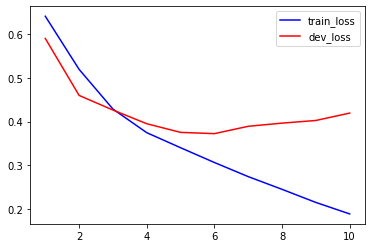

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1), train_loss_epoch_list, color="b", label="train_loss")

plt.plot(range(1, epochs+1), dev_loss_epoch_list, color="r", label="dev_loss")

plt.legend()
plt.show()

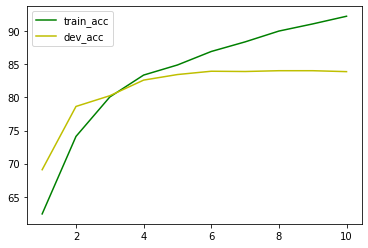

In [15]:
plt.plot(range(1, epochs+1), train_acc_epoch_list, color="g", label="train_acc")
plt.plot(range(1, epochs+1), dev_acc_epoch_list, color="y", label="dev_acc")
plt.legend()
plt.show()

## 预测

In [40]:
## 我们以一张图片
import random
test_path_list = os.listdir("../../datasets/cat_dog_dataset/test/")
test_path_list = [os.path.join("../../datasets/cat_dog_dataset/test/", fileanme) for fileanme in test_path_list]
nums = len(test_path_list)
random_num = random.randint(0, nums)
random_pic = test_path_list[random_num]

test_transform = torchvision.transforms.transforms.Compose(
[
    torchvision.transforms.Resize(size=(227, 227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
])

test_img = PIL.Image.open(random_pic).convert('RGB')

In [41]:
test_img_t = test_transform(test_img)
test_img_t.unsqueeze_(0)## 扩展维度[bchw]
test_img_t.size()

torch.Size([1, 3, 227, 227])

In [42]:
molde = AlexNet(args)
model.load_state_dict(torch.load("../../results/AlexNet/alexnet.pt"))
model = model.to(device)
test_img_t = test_img_t.to(device)
mapping = {1:"dog", 0:"cat"}
with torch.no_grad():
    logits = model(test_img_t)
    pre = torch.softmax(logits, dim=1)
    pre = pre.argmax(dim=1)
    print(pre)


tensor([0], device='cuda:0')


In [43]:
label = pre.item()
label_txt = mapping[label]

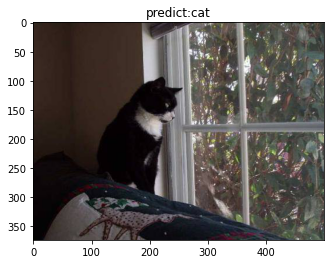

In [44]:
plt.imshow(test_img)
plt.title("predict:{}".format(label_txt))
plt.show()